In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import gc
#import statsmodels.api as sm
#from statsmodels.genmod.families import NegativeBinomial
#import multiprocessing as mp

os.chdir('../..')
os.getcwd()

'/home/vschuste/projects/interpreting_omics_models'

## some tests (don't know what to do here yet)

In [2]:
# load model and data

dev_id = 2
device = torch.device(f"cuda:{dev_id}" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {device}")
    data_dir = '/home/vschuste/data/singlecell/'
else:
    data_dir = '/Users/vschuste/Documents/work/data/singlecell/'

data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e').to(device)
data = data[data.obs["train_val_test"] == "train"]
library = data.obs['GEX_n_counts'].values
data_gene_names = (data.var[data.var['modality'] == 'GEX']).index
data_gene_ids = data.var[data.var['modality'] == 'GEX']['gene_id'].values
del data
gc.collect()
# get the model's dispersions for the DEG test
with torch.no_grad():
    dispersion_factors = (torch.exp(model.decoder.out_modules[0].distribution.log_r).detach().cpu().numpy() + 1).flatten()

reps = model.representation.z.detach()

Using GPU: cuda:0
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


In [3]:
import torch.nn as nn

class SparseAutoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            #nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'

input_size = reps.shape[1]
hidden_size = 10**4
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))
sae_model.to(device)

activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

In [4]:
active_feature_ids = torch.where(activations.sum(dim=0) > 0)[0]
print(len(active_feature_ids))

5318


In [8]:
# get all sae parameters and names
for i, (name, param) in enumerate(sae_model.named_parameters()):
    print(i, name, param.shape)

0 encoder.0.weight torch.Size([10000, 20])
1 encoder.0.bias torch.Size([10000])
2 decoder.0.weight torch.Size([20, 10000])
3 decoder.0.bias torch.Size([20])


# automated analysis

## RNA

In [2]:
# first load the gene hits numpy data
gene_hits = np.load('03_results/reports/sc_dgd_sae_gene_hits_per_feature.npy')

In [ ]:
hits_per_feature = gene_hits.sum(axis=1)
hits_per_gene = gene_hits.sum(axis=0)

4352 13431


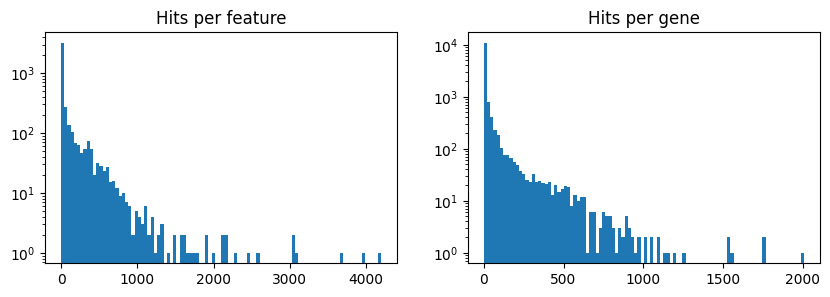

In [7]:
# plot histograms of both

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(hits_per_feature, bins=100)
ax[0].set_title('Hits per feature')
ax[0].set_yscale('log')
ax[1].hist(hits_per_gene, bins=100)
ax[1].set_title('Hits per gene')
ax[1].set_yscale('log')
plt.show()

/tmp/ipykernel_354724/3425796532.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_a

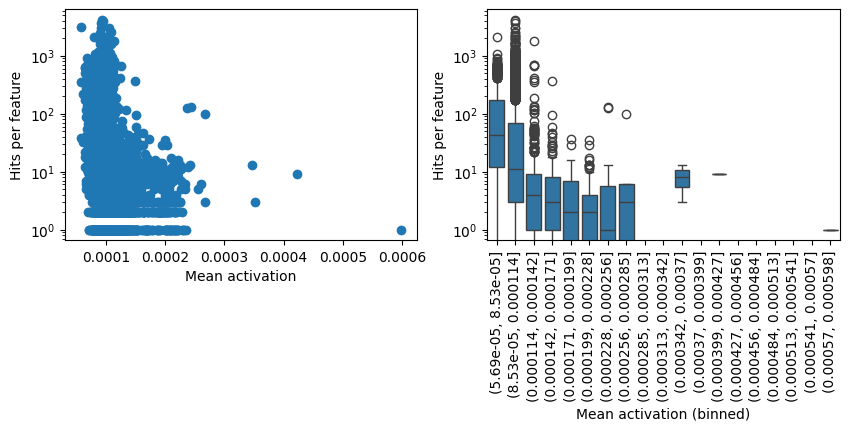

In [19]:
# look at relationship between feature hits and mean activations
activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')
active_feature_ids = torch.where(activations.sum(dim=0) > 0)[0]
n_zeros_per_feature = (activations == 0).sum(dim=0)
nonzero_feats = torch.where(n_zeros_per_feature > activations.shape[0] - 100)[0]
active_feature_ids = torch.Tensor(list(set(active_feature_ids.numpy()).intersection(set(nonzero_feats.numpy())))).long()

mean_activations = activations[active_feature_ids,:].mean(dim=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].scatter(mean_activations, hits_per_feature)
ax[0].set_xlabel('Mean activation')
ax[0].set_ylabel('Hits per feature')
ax[0].set_yscale('log')
# next a binned boxplot
# bins should be created for mean activations
bins = np.linspace(mean_activations.min(), mean_activations.max(), 20)
temp_df = pd.DataFrame({'mean_activations': mean_activations, 'hits_per_feature': hits_per_feature})
temp_df['mean_activations_bin'] = pd.cut(temp_df['mean_activations'], bins=bins)
sns.boxplot(x='mean_activations_bin', y='hits_per_feature', data=temp_df, ax=ax[1])
plt.xticks(rotation=90)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mean activation (binned)')
ax[1].set_ylabel('Hits per feature')
plt.show()

In [ ]:
# look at relationship between gene hits and mean expression

data_dir = '/home/vschuste/data/singlecell/'
data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')

modality_switch = len(data.var[data.var['modality'] == 'GEX'])
mean_expression = np.asarray(data.layers['counts'][:,:modality_switch].mean(axis=0)).flatten()
log_mean_expression = np.log1p(mean_expression)

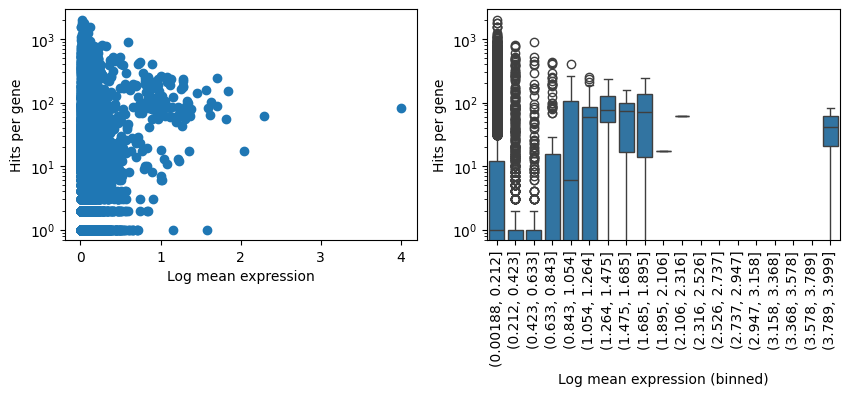

In [33]:
# plot the relationship

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].scatter(log_mean_expression, hits_per_gene)
ax[0].set_xlabel('Log mean expression')
ax[0].set_ylabel('Hits per gene')
ax[0].set_yscale('log')
# next a binned boxplot
# bins should be created for mean activations
bins = np.linspace(log_mean_expression.min(), log_mean_expression.max(), 20)
temp_df = pd.DataFrame({'mean_expression': log_mean_expression, 'hits_per_gene': hits_per_gene})
temp_df['mean_expression_bin'] = pd.cut(temp_df['mean_expression'], bins=bins)
sns.boxplot(x='mean_expression_bin', y='hits_per_gene', data=temp_df, ax=ax[1])
plt.xticks(rotation=90)
ax[1].set_yscale('log')
ax[1].set_xlabel('Log mean expression (binned)')
ax[1].set_ylabel('Hits per gene')
plt.show()

In [35]:
# lets try against dispersion factor

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e')
with torch.no_grad():
    dispersion_factors = (torch.exp(model.decoder.out_modules[0].distribution.log_r).detach().cpu().numpy() + 1).flatten()

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._sa

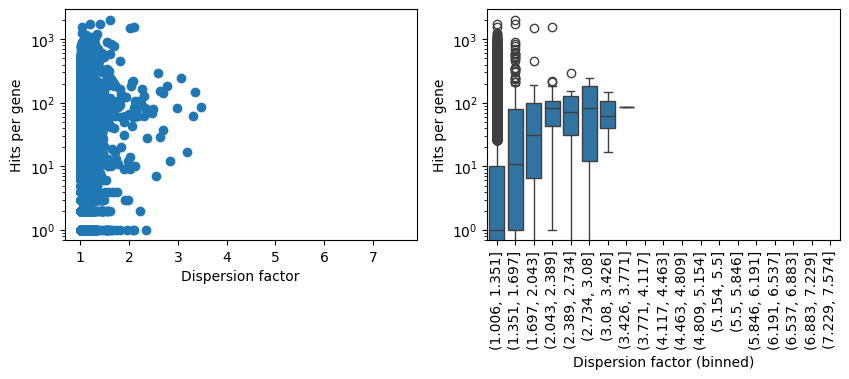

In [36]:
# plot relationship

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].scatter(dispersion_factors, hits_per_gene)
ax[0].set_xlabel('Dispersion factor')
ax[0].set_ylabel('Hits per gene')
ax[0].set_yscale('log')
# next a binned boxplot
# bins should be created for mean activations
bins = np.linspace(dispersion_factors.min(), dispersion_factors.max(), 20)
temp_df = pd.DataFrame({'dispersion_factors': dispersion_factors, 'hits_per_gene': hits_per_gene})
temp_df['dispersion_factors_bin'] = pd.cut(temp_df['dispersion_factors'], bins=bins)
sns.boxplot(x='dispersion_factors_bin', y='hits_per_gene', data=temp_df, ax=ax[1])
plt.xticks(rotation=90)
ax[1].set_yscale('log')
ax[1].set_xlabel('Dispersion factor (binned)')
ax[1].set_ylabel('Hits per gene')
plt.show()

In [3]:
# look at the dataframe with GO term analysis

go_df = pd.read_csv('03_results/reports/sc_dgd_sae_go_analysis.csv')

In [6]:
go_df

n_hits  expected  binom_pval binom_direction  binom_fold_change   fdr  \
0           1  0.001787    0.001786               +         559.625000  0.50   
1           1  0.004169    0.004165               +         239.839286  0.50   
2           1  0.008488    0.008470               +         117.815789  0.50   
3           1  0.009530    0.009507               +         104.929688  0.50   
4           1  0.009828    0.009804               +         101.750000  0.50   
...       ...       ...         ...             ...                ...   ...   
95263       1  0.040950    0.040155               +          24.420000  0.96   
95264       1  0.042811    0.041943               +          23.358261  0.96   
95265       1  0.042811    0.041943               +          23.358261  0.96   
95266       1  0.044673    0.043728               +          22.385000  0.96   
95267       3  0.308987    0.003543               +           9.709157  0.88   

        z_score   mw_pval  effect_size       go_id  \
0     -2.020111  0.021686     0.331576  GO:0007187   
1     -2.048834  0.020239     0.388106  GO:0043087   
2     -2.173695  0.014864     0.416707  GO:0007204   
3     -2.367738  0.008949     0.414354  GO:0007268   
4     -2.745577  0.003020     0.402196  GO:0019722   
...         ...       ...          ...         ...   
95263 -1.915534  0.027712     0.617994  GO:0071392   
95264 -3.063435  0.001094     0.315438  GO:0032703   
95265 -1.720316  0.042687     0.396356  GO:0048813   
95266 -2.687423  0.003600     0.658506  GO:0010971   
95267 -4.594657  0.000002     0.396408  GO:0007186   

                                                 go_name  go_level  feature  \
0      G protein-coupled receptor signaling pathway, ...         4     8192   
1                          regulation of GTPase activity         5     8192   
2      positive regulation of cytosolic calcium ion c...         3     8192   
3                         chemical synaptic transmission         7     8192   
4                             calcium-mediated signaling         5     8192   
...                                                  ...       ...      ...   
95263            cellular response to estradiol stimulus         5     8190   
95264    negative regulation of interleukin-2 production         6     8190   
95265                             dendrite morphogenesis         6     8190   
95266  positive regulation of G2/M transition of mito...         8     8190   
95267       G protein-coupled receptor signaling pathway         3     8190   

       p_threshold  fold_change_threshold  
0          0.00001                    2.0  
1          0.00001                    2.0  
2          0.00001                    2.0  
3          0.00001                    2.0  
4          0.00001                    2.0  
...            ...                    ...  
95263      0.00001                    NaN  
95264      0.00001                    NaN  
95265      0.00001                    NaN  
95266      0.00001                    NaN  
95267      0.00001                    NaN  

[95268 rows x 15 columns]

In [116]:
# add information on local and global features and which celltype they match with

activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

data_dir = '/home/vschuste/data/singlecell/'
data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')
model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e')
data = data[data.obs["train_val_test"] == "train"]

/tmp/ipykernel_446738/1121049783.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_a

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._sa

In [117]:
# go through all cell types and compute each features mean activation and std for ct positive and negative
cell_types = [x for x in data.obs['cell_type'].unique()]
means_positive = torch.zeros((len(cell_types), activations.shape[1]))
se_positive = torch.zeros((len(cell_types), activations.shape[1]))
means_negative = torch.zeros((len(cell_types), activations.shape[1]))
se_negative = torch.zeros((len(cell_types), activations.shape[1]))
for i, ct in enumerate(cell_types):
    data_indices = data.obs['cell_type'] == ct
    activations_pos = activations[data_indices,:]
    activations_neg = activations[~data_indices,:]
    means_positive[i,:] = torch.mean(activations_pos, dim=0).detach().cpu()
    # compute the standard error of the mean
    se_positive[i,:] = torch.std(activations_pos, dim=0).detach().cpu() / math.sqrt(activations_pos.shape[0])
    means_negative[i,:] = torch.mean(activations_neg, dim=0).detach().cpu()
    se_negative[i,:] = torch.std(activations_neg, dim=0).detach().cpu() / math.sqrt(activations_neg.shape[0])
# that gives the "significant features" per cell type
significant_features = torch.BoolTensor((means_positive - means_negative) > 1.96*(se_positive + se_negative))
sum_significant_features = torch.sum(significant_features, dim=0)

###
# unique (local) vs shared (global) features, and there is a thing in the middle which I call regional
###
# all active features
active_features = (torch.where(torch.sum(activations, dim=0) != 0)[0]).tolist()
# local features are the ct specific ones
local_features = (torch.where(sum_significant_features == 1)[0]).tolist()
regional_features = (torch.where(sum_significant_features > 1)[0]).tolist()
# all remaining active features are global
global_features = list(set(active_features).difference(set(local_features).union(set(regional_features))))
print('{} active features, {} local features, {} regional features, {} global features'.format(len(active_features), len(local_features), len(regional_features), len(global_features)))

5318 active features, 908 local features, 1072 regional features, 3338 global features


In [120]:
# combine regional and global
global_features.extend(regional_features)

In [121]:
# go through them by celltype

unique_ct_features = {}
unique_ct_feature_indices = torch.where(sum_significant_features == 1)[0]
for i, ct in enumerate(cell_types):
    ct_features_temp = torch.where(significant_features[i,:])[0]
    # get the intersection with the unique features
    intersect_feats = list(set(list(ct_features_temp.numpy())).intersection(set(list(unique_ct_feature_indices.numpy()))))
    unique_ct_features[ct] = intersect_feats
    print('Cell type: {}, # unique features: {}'.format(ct, len(intersect_feats)))

Cell type: Naive CD20+ B, # unique features: 15
Cell type: CD14+ Mono, # unique features: 118
Cell type: CD8+ T, # unique features: 12
Cell type: CD16+ Mono, # unique features: 128
Cell type: B1 B, # unique features: 35
Cell type: Lymph prog, # unique features: 23
Cell type: CD4+ T naive, # unique features: 13
Cell type: CD4+ T activated, # unique features: 11
Cell type: Erythroblast, # unique features: 123
Cell type: Normoblast, # unique features: 141
Cell type: NK, # unique features: 4
Cell type: ILC, # unique features: 19
Cell type: Transitional B, # unique features: 25
Cell type: G/M prog, # unique features: 31
Cell type: MK/E prog, # unique features: 0
Cell type: HSC, # unique features: 21
Cell type: pDC, # unique features: 19
Cell type: ID2-hi myeloid prog, # unique features: 28
Cell type: Proerythroblast, # unique features: 104
Cell type: Plasma cell, # unique features: 8
Cell type: cDC2, # unique features: 28
Cell type: CD8+ T naive, # unique features: 2


In [8]:
go_df_feat_types = []
go_df_celltypes = []

for i in range(len(go_df)):
    feat = go_df['feature'][i]
    if feat in local_features:
        go_df_feat_types.append('local')
        # get which celltype it is unique to
        for ct in cell_types:
            if feat in unique_ct_features[ct]:
                go_df_celltypes.append(ct)
                break
    elif feat in global_features:
        go_df_feat_types.append('global')
        go_df_celltypes.append('')
    else:
        go_df_feat_types.append('')
        go_df_celltypes.append('')

go_df['feature_type'] = go_df_feat_types
go_df['celltype'] = go_df_celltypes

In [14]:
# list all unique go terms per cell type

for ct in cell_types:
    print('Cell type: {}'.format(ct))
    temp_df = go_df[(go_df['feature_type'] == 'local') & (go_df['celltype'] == ct)]
    # print the head
    print(temp_df.head()['go_name'])
    #print(go_df[(go_df['feature_type'] == 'local') & (go_df['celltype'] == ct)]['go_name'].unique())

Cell type: Naive CD20+ B
249             homologous chromosome pairing at meiosis
250                           DNA replication initiation
251    positive regulation of G1/S transition of mito...
252                                 telomere maintenance
253                G1/S transition of mitotic cell cycle
Name: go_name, dtype: object
Cell type: CD14+ Mono
2074            DNA unwinding involved in DNA replication
2075    negative regulation of cell migration involved...
2076    double-strand break repair via break-induced r...
2077    G protein-coupled receptor signaling pathway, ...
2078                       endothelial cell proliferation
Name: go_name, dtype: object
Cell type: CD8+ T
7986    G protein-coupled receptor signaling pathway, ...
7987                        regulation of GTPase activity
7988                                    blood coagulation
7989    positive regulation of peptidyl-tyrosine phosp...
7990                             neuron apoptotic process
Name: go_nam

In [17]:
b1b_df = go_df[(go_df['feature_type'] == 'local') & (go_df['celltype'] == 'B1 B')]

# list all go terms per feature
for feat in b1b_df['feature'].unique():
    print('Feature: {}'.format(feat))
    feat_df = b1b_df[b1b_df['feature'] == feat]
    print(feat_df.head()['go_name'].values)

Feature: 227
['hydrogen peroxide catabolic process'
 'positive regulation of mitotic metaphase/anaphase transition'
 'antibacterial humoral response' 'heme biosynthetic process'
 'anaphase-promoting complex-dependent catabolic process']
Feature: 271
['cellular response to epinephrine stimulus'
 'cellular response to insulin stimulus']
Feature: 8722
['regulation of DNA-templated DNA replication initiation'
 'double-strand break repair via break-induced replication'
 'chromosome condensation' 'negative regulation of DNA recombination'
 'DNA unwinding involved in DNA replication']
Feature: 583
['antibacterial humoral response'
 'immunoglobulin mediated immune response']
Feature: 9024
['positive regulation of mitotic metaphase/anaphase transition'
 'kinetochore assembly' 'metaphase chromosome alignment'
 'regulation of chromosome segregation'
 'attachment of mitotic spindle microtubules to kinetochore']
Feature: 1176
['cellular response to interleukin-4' 'protein refolding'
 'copper ion tr

In [19]:
len(b1b_df['feature'].unique())

23

In [167]:
# load the PCA
df_pca = pd.read_csv("03_results/reports/human_bonemarrow_l20_h2-3_test50e_pca.csv")

feat_palette = sns.color_palette('rocket_r', as_cmap=True)

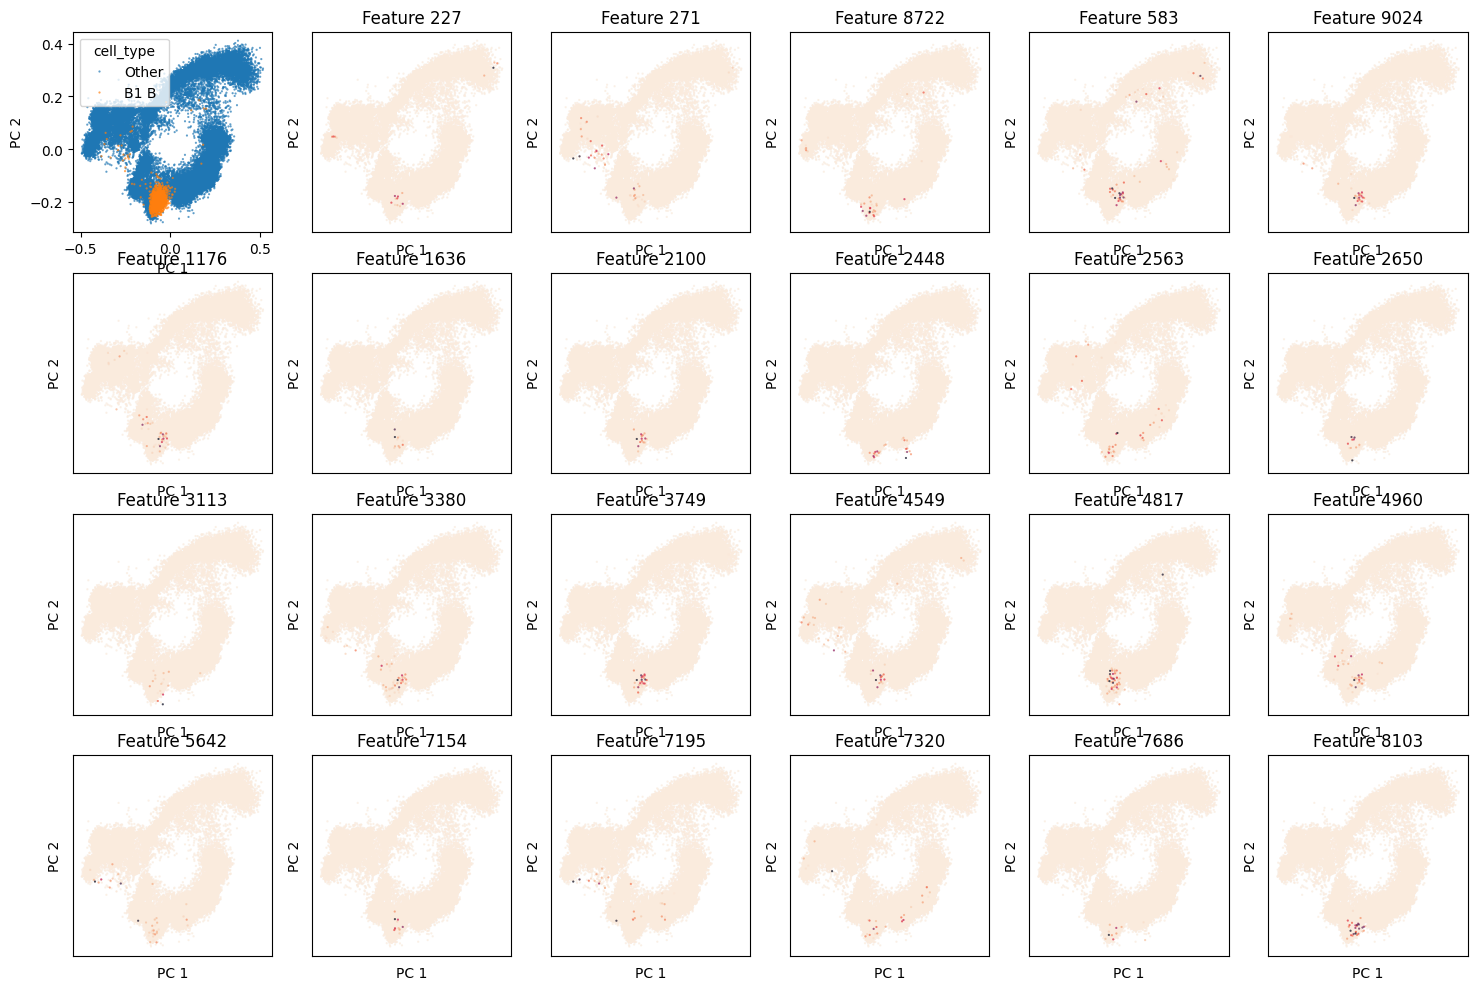

In [36]:
# plot the activations of each feature in b1b

n_cols = 6
n_rows = math.ceil(len(b1b_df['feature'].unique()+1) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# first plot should just show the location of the cell type
df_temp = df_pca.copy()
df_temp['cell_type'] = ['B1 B' if x == 'B1 B' else 'Other' for x in data.obs['cell_type']]
# sort by cell type (with B1 B last)
df_temp = df_temp.sort_values(by='cell_type', ascending=False)
sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='cell_type', s=2, alpha=0.7, ec=None, ax=ax[0,0])

for j, feat in enumerate(b1b_df['feature'].unique()):
    i = j+1
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,feat]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(feat))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

In [34]:
# count how often each unique go term appears in the b1b features
print(b1b_df['go_name'].value_counts())

hydrogen peroxide catabolic process                             5
G1/S transition of mitotic cell cycle                           5
G protein-coupled receptor signaling pathway                    5
positive regulation of mitotic cell cycle                       4
positive regulation of mitotic metaphase/anaphase transition    4
                                                               ..
mitochondrial respiratory chain complex III assembly            1
ATP biosynthetic process                                        1
mitochondrial electron transport, ubiquinol to cytochrome c     1
retina layer formation                                          1
ERAD pathway                                                    1
Name: go_name, Length: 228, dtype: int64


In [37]:
cd20nb_df = go_df[(go_df['feature_type'] == 'local') & (go_df['celltype'] == 'Naive CD20+ B')]

# list all go terms per feature
for feat in cd20nb_df['feature'].unique():
    print('Feature: {}'.format(feat))
    feat_df = cd20nb_df[cd20nb_df['feature'] == feat]
    print(feat_df.head()['go_name'].values)

Feature: 8213
['homologous chromosome pairing at meiosis' 'DNA replication initiation'
 'positive regulation of G1/S transition of mitotic cell cycle'
 'telomere maintenance' 'G1/S transition of mitotic cell cycle']
Feature: 614
['response to cAMP' 'DNA replication initiation' 'glycolytic process'
 'positive regulation of G1/S transition of mitotic cell cycle'
 'response to nutrient']
Feature: 9283
['double-strand break repair via break-induced replication'
 'regulation of DNA-templated DNA replication initiation'
 'DNA unwinding involved in DNA replication' 'regulation of mitophagy'
 'microtubule-based process']
Feature: 1157
['antibacterial humoral response'
 'positive regulation of lipopolysaccharide-mediated signaling pathway'
 'immunoglobulin mediated immune response'
 'B cell receptor signaling pathway' 'heme biosynthetic process']
Feature: 3087
['regulation of DNA-templated DNA replication initiation'
 'double-strand break repair via break-induced replication'
 'DNA unwinding in

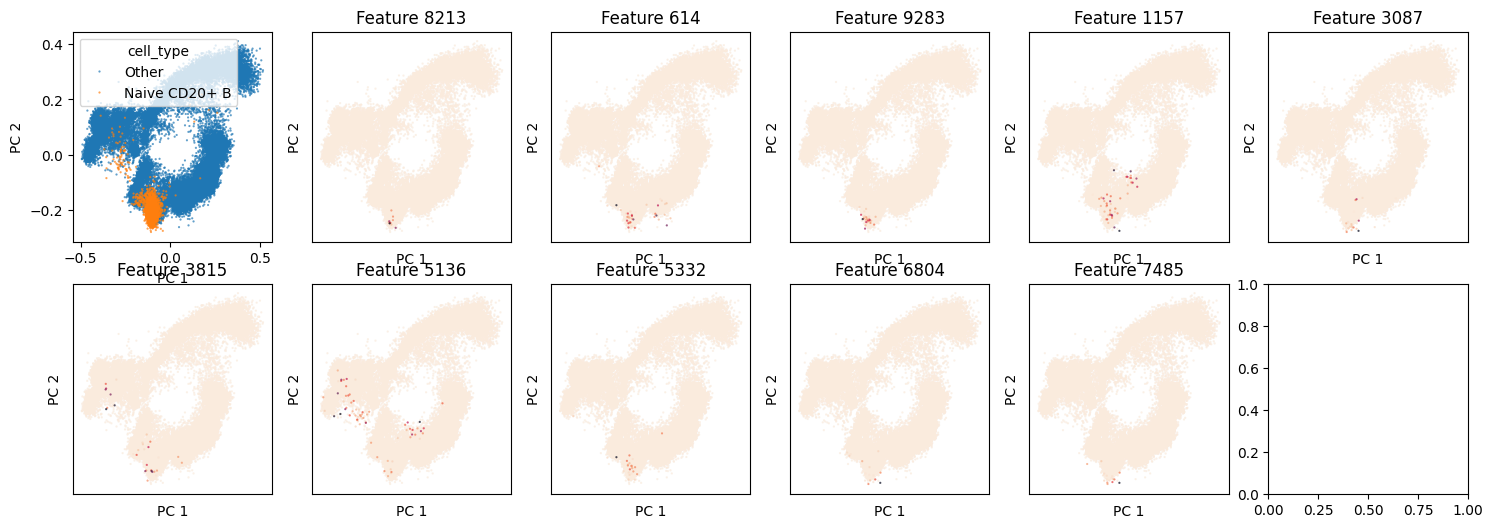

In [38]:
# create the same plot as for b1b

n_cols = 6
n_rows = math.ceil(len(cd20nb_df['feature'].unique()+1) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# first plot should just show the location of the cell type
df_temp = df_pca.copy()
df_temp['cell_type'] = ['Naive CD20+ B' if x == 'Naive CD20+ B' else 'Other' for x in data.obs['cell_type']]
# sort by cell type (with Naive CD20+ B last)
df_temp = df_temp.sort_values(by='cell_type', ascending=False)
sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='cell_type', s=2, alpha=0.7, ec=None, ax=ax[0,0])

for j, feat in enumerate(cd20nb_df['feature'].unique()):
    i = j+1
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,feat]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(feat))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

In [39]:
# and now the same for transitional b cells

tb_df = go_df[(go_df['feature_type'] == 'local') & (go_df['celltype'] == 'Transitional B')]
# list all go terms per feature
for feat in tb_df['feature'].unique():
    print('Feature: {}'.format(feat))
    feat_df = tb_df[tb_df['feature'] == feat]
    print(feat_df.head()['go_name'].values)

Feature: 8247
['double-strand break repair via break-induced replication'
 'regulation of DNA-templated DNA replication initiation'
 'DNA unwinding involved in DNA replication'
 'DNA replication checkpoint signaling'
 'homologous chromosome pairing at meiosis']
Feature: 8588
['mitotic spindle assembly checkpoint signaling'
 'heme A biosynthetic process' 'regulation of chromosome segregation'
 'positive regulation of mitotic metaphase/anaphase transition'
 'positive regulation of mitotic cell cycle spindle assembly checkpoint']
Feature: 9329
['copper ion transport' 'homologous chromosome pairing at meiosis'
 'long-chain fatty-acyl-CoA biosynthetic process'
 'DNA replication initiation'
 'positive regulation of G1/S transition of mitotic cell cycle']
Feature: 9873
['positive regulation of NF-kappaB transcription factor activity'
 'positive regulation of canonical NF-kappaB signal transduction']
Feature: 2313
['adaptive immune response']
Feature: 2665
['long-chain fatty-acyl-CoA biosynthe

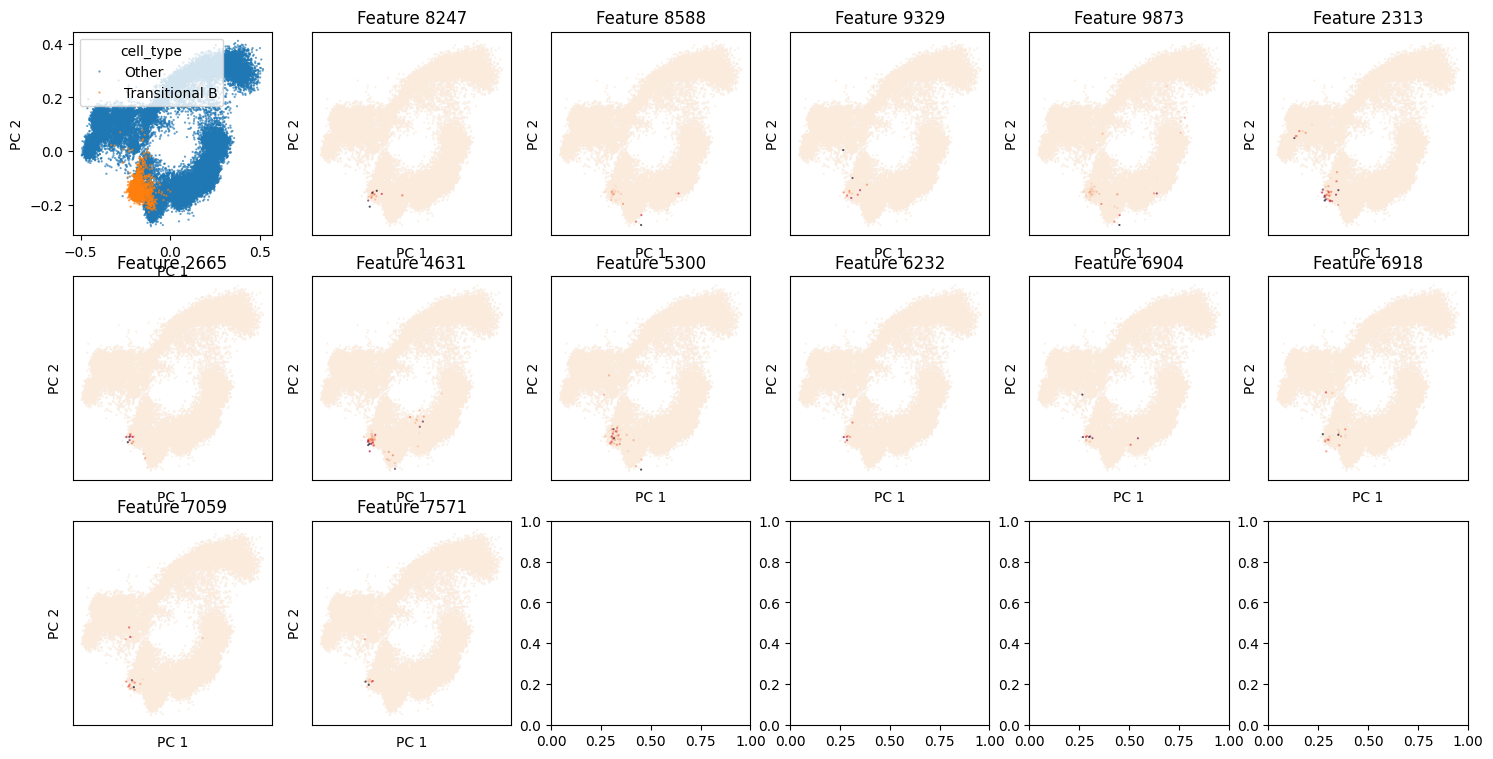

In [41]:
# and the plot

n_cols = 6
n_rows = math.ceil(len(tb_df['feature'].unique()+1) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# first plot should just show the location of the cell type
df_temp = df_pca.copy()
df_temp['cell_type'] = ['Transitional B' if x == 'Transitional B' else 'Other' for x in data.obs['cell_type']]
# sort by cell type (with Transitional B last)
df_temp = df_temp.sort_values(by='cell_type', ascending=True)
sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='cell_type', s=2, alpha=0.7, ec=None, ax=ax[0,0])

for j, feat in enumerate(tb_df['feature'].unique()):
    i = j+1
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,feat]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(feat))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

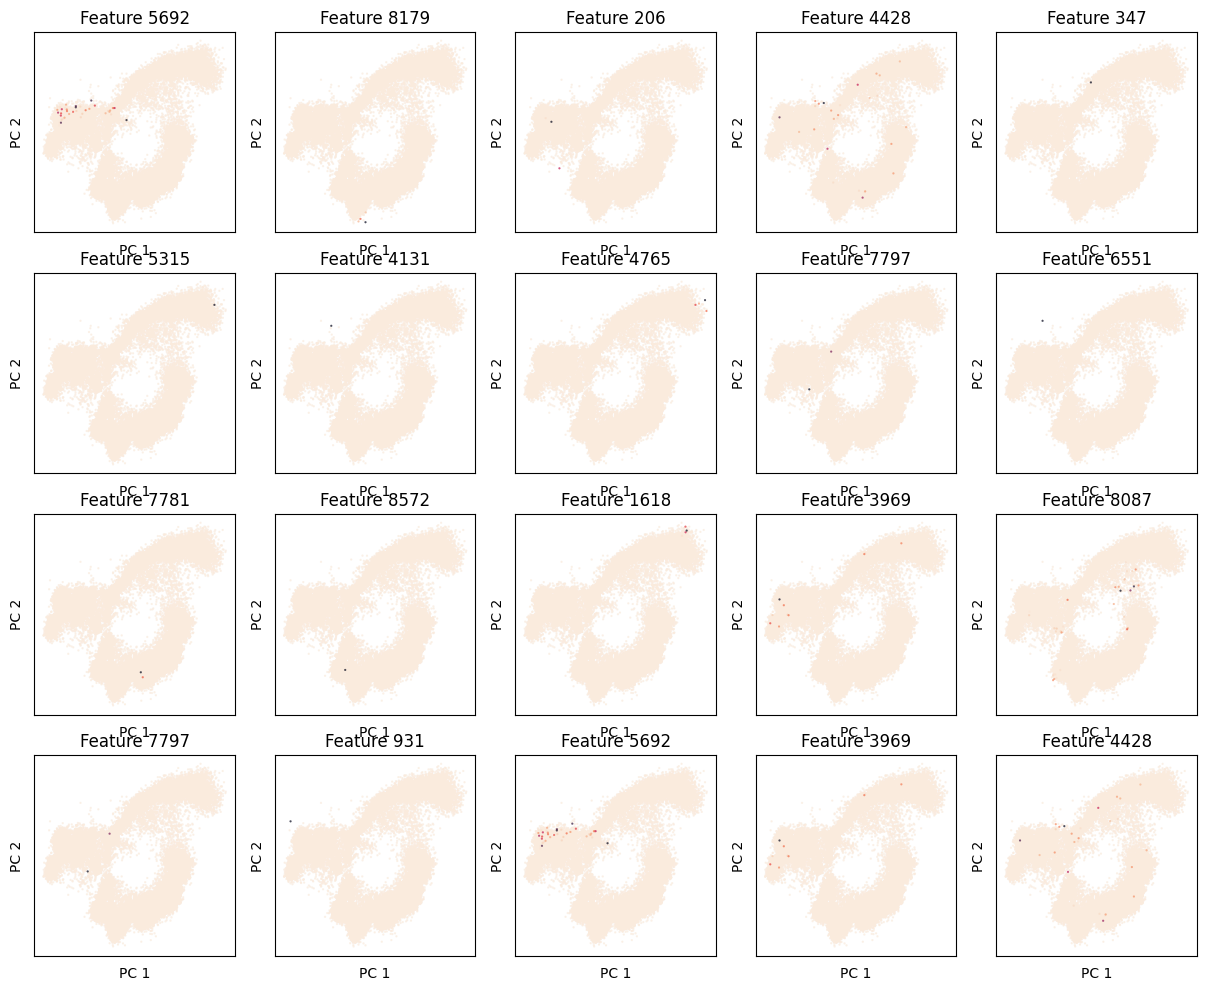

In [45]:
# now look at some global features

global_df = go_df[(go_df['feature_type'] == 'global')]

# sort the df by fold change and plot the top 20 features

global_df = global_df.sort_values(by='binom_fold_change', ascending=False)

n_cols = 5
n_rows = math.ceil(20 / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for i in range(20):
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,global_df['feature'].iloc[i]]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(global_df['feature'].iloc[i]))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

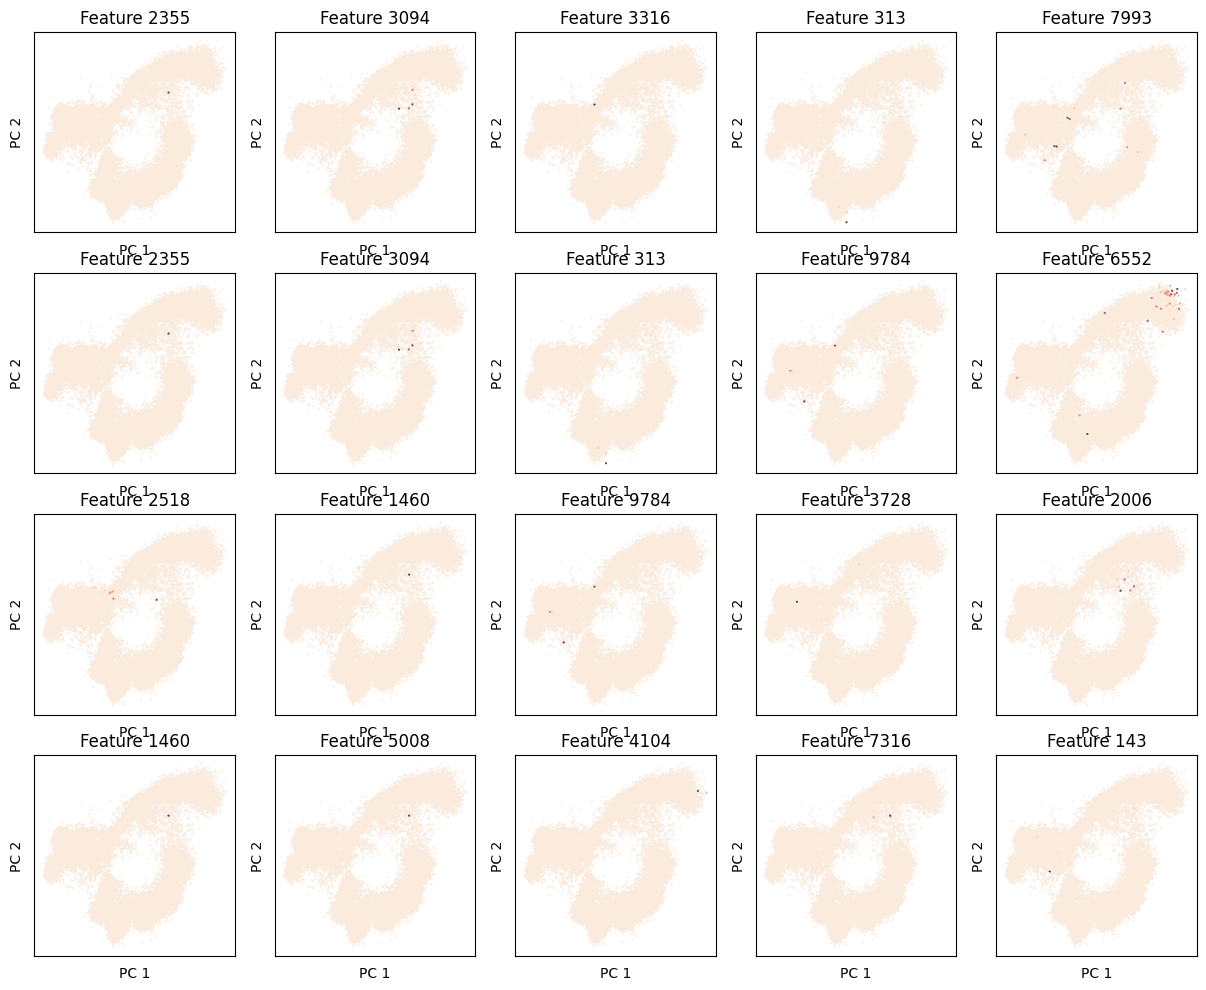

In [47]:
# now look at some global features

global_df = go_df[(go_df['feature_type'] == 'global')]

# sort the df by fold change and plot the top 20 features

global_df = global_df.sort_values(by='effect_size', ascending=False)

n_cols = 5
n_rows = math.ceil(20 / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for i in range(20):
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,global_df['feature'].iloc[i]]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(global_df['feature'].iloc[i]))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

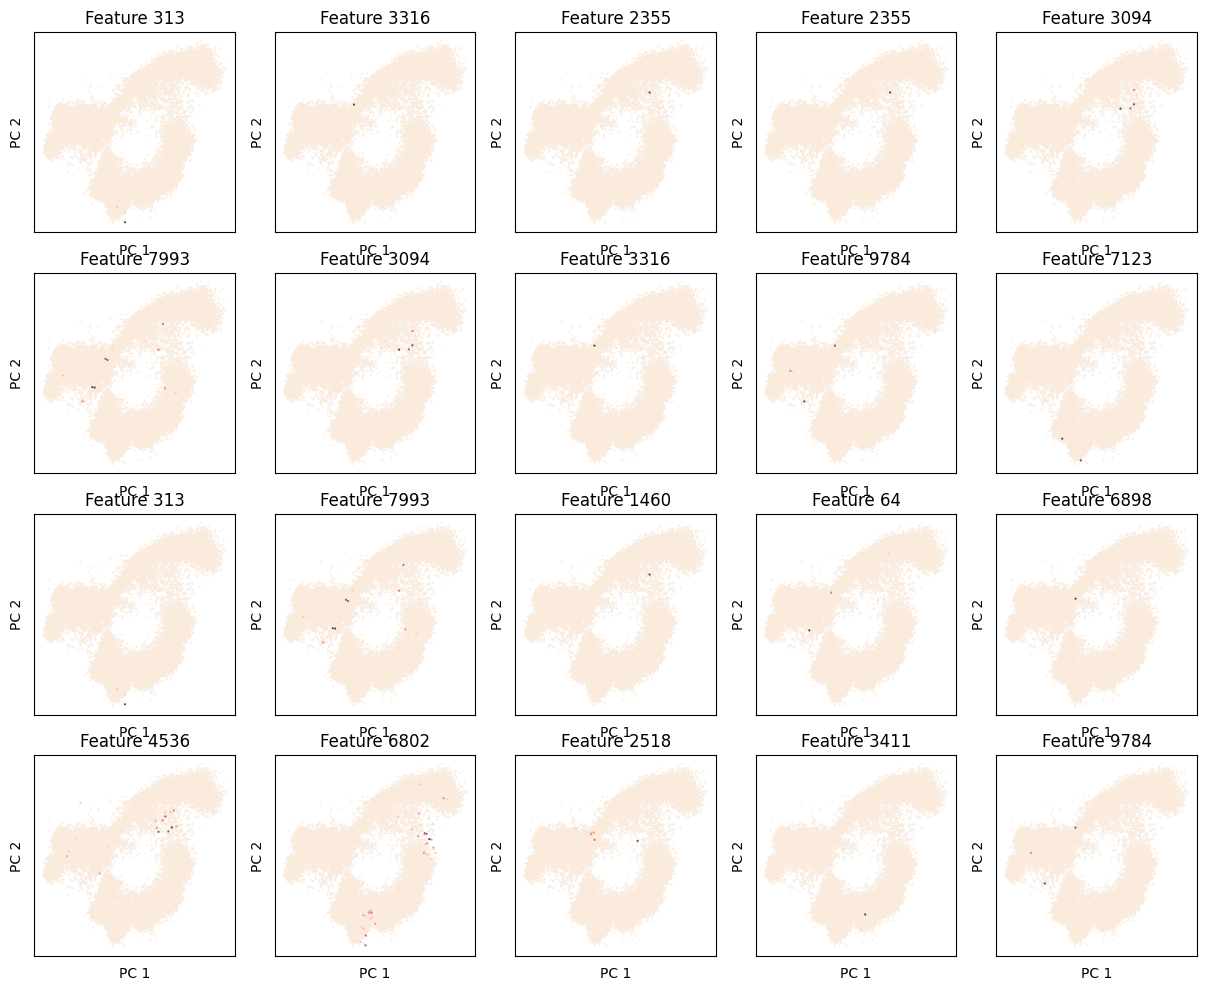

In [48]:
# now look at some global features

global_df = go_df[(go_df['feature_type'] == 'global')]

# sort the df by fold change and plot the top 20 features

global_df = global_df.sort_values(by='mw_pval', ascending=True)

n_cols = 5
n_rows = math.ceil(20 / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for i in range(20):
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,global_df['feature'].iloc[i]]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(global_df['feature'].iloc[i]))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

/tmp/ipykernel_366697/3495118005.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_df['n_active_cells'] = global_df['feature'].apply(lambda x: torch.sum(activations[:,x] != 0).item())


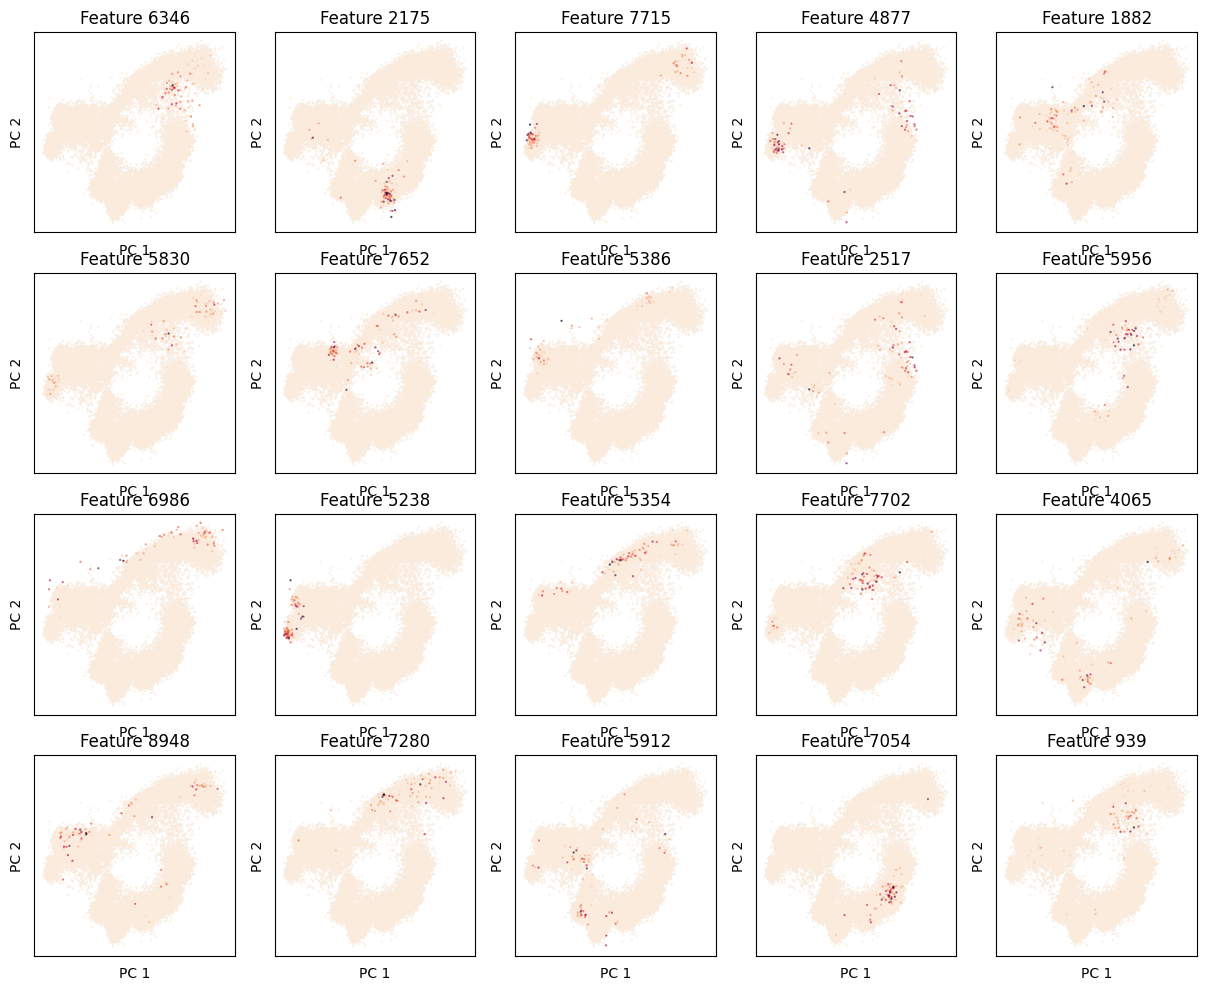

In [53]:
# now look at some global features

global_df = go_df[(go_df['feature_type'] == 'global')]
global_df['n_active_cells'] = global_df['feature'].apply(lambda x: torch.sum(activations[:,x] != 0).item())

# sort the df by fold change and plot the top 20 features

global_df = global_df.sort_values(by='n_active_cells', ascending=False)
global_df_unique = global_df['feature'].unique()

n_cols = 5
n_rows = math.ceil(20 / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for i, feat in enumerate(global_df_unique[:20]):
    df_temp = df_pca.copy()
    df_temp['activations'] = activations[:,feat]
    # sort by activations
    df_temp = df_temp.sort_values(by='activations', ascending=True)
    sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='activations', s=2, alpha=0.7, ec=None, palette=feat_palette, ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title('Feature {}'.format(feat))
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    # remove the legend
    ax[i//n_cols, i%n_cols].get_legend().remove()
plt.show()

In [55]:
# show the GO terms for each of these global features

for feat in global_df_unique[:20]:
    print('Feature: {}'.format(feat))
    feat_df = go_df[go_df['feature'] == feat]
    print(feat_df.head()['go_name'].values)

Feature: 6346
['regulation of DNA-templated DNA replication initiation'
 'chromosome condensation'
 'double-strand break repair via break-induced replication'
 'negative regulation of DNA recombination'
 'DNA unwinding involved in DNA replication']
Feature: 2175
['heme A biosynthetic process' 'regulation of chromosome segregation'
 'attachment of mitotic spindle microtubules to kinetochore'
 'metaphase chromosome alignment'
 'regulation of DNA-templated DNA replication initiation']
Feature: 7715
['double-strand break repair via break-induced replication'
 'regulation of DNA-templated DNA replication initiation'
 'DNA unwinding involved in DNA replication'
 'fatty acid beta-oxidation using acyl-CoA dehydrogenase'
 'DNA replication initiation']
Feature: 4877
['cilium movement'
 'cellular response to hepatocyte growth factor stimulus'
 'microtubule depolymerization'
 'positive regulation of cell migration involved in sprouting angiogenesis'
 'oligosaccharide biosynthetic process']
Feature

In [64]:
# how many of our active features did we cover in this analysis?

print('Number of active features: {}'.format(len(active_features)))
print('Number of active features covered: {}'.format(len(go_df['feature'].unique())))
print('i.e. {:.2f}%'.format(100*len(go_df['feature'].unique())/len(active_features)))

n_zeros_per_feature = (activations == 0).sum(dim=0)
nonzero_feats = torch.where(n_zeros_per_feature > activations.shape[0] - 100)[0]
analyzed_feature_ids = list(set(active_features).intersection(set(nonzero_feats.numpy())))

print('after having excluded {} features ({:.2f}%) based on a 100 cell threshold'.format(len(active_features) - len(analyzed_feature_ids), 100*(len(active_features) - len(analyzed_feature_ids))/len(active_features)))
print('So we covered {:.2f}% of the {} analyzed features'.format(100*len(go_df['feature'].unique())/len(analyzed_feature_ids), len(analyzed_feature_ids)))

Number of active features: 5318
Number of active features covered: 3523
i.e. 66.25%
after having excluded 966 features (18.16%) based on a 100 cell threshold
So we covered 80.95% of the 4352 analyzed features


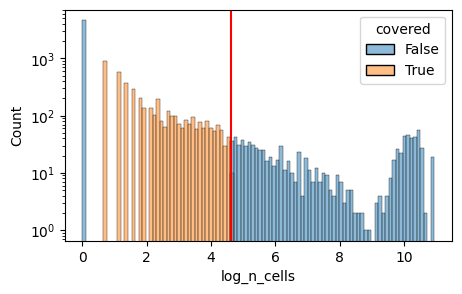

In [73]:
# plot a histogram of covered vs non covered features wrt the number of cells

temp_df = pd.DataFrame({
    'n_cells': (activations.shape[0] - n_zeros_per_feature).numpy(),
    'covered': [x in analyzed_feature_ids for x in range(activations.shape[1])]
})

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# create logwise bins
temp_df['log_n_cells'] = np.log1p(temp_df['n_cells'])
sns.histplot(data=temp_df, x='log_n_cells', hue='covered', bins=100, ax=ax)
# set a line at log1p(100)
ax.axvline(x=np.log1p(100), color='red')
#sns.histplot(data=temp_df, x='n_cells', hue='covered', bins=100, ax=ax)
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show()

In [74]:
# I accidentally did my selection of at least 100 cells wrong, got up to 100
(activations.shape[0] - n_zeros_per_feature)[torch.where(n_zeros_per_feature > activations.shape[0] - 100)[0]]

tensor([ 0,  0,  4,  ..., 13, 27,  4])

In [76]:
(activations.shape[0] - n_zeros_per_feature)[torch.where(n_zeros_per_feature < (activations.shape[0] - 100))[0]]

tensor([ 4436,   171, 23495,   841,   121,   317,   418, 26903,   480,   643,
         2093,   149,   152,   283, 20434,   215, 35059,  1275,  4333,   181,
        32621,   394,   192, 34388,   304,   200,  1519, 20470,   304,   290,
          137, 39333,   541,  3289, 24970,   104,   417, 20999,   312, 16472,
        22197,   438, 15442,   567,   592,   167, 17381, 25286,  2697,   191,
          107,   724, 32840,   361,   718, 30278, 55474, 33721,   240, 12712,
        28636, 29734,   218,   115,   143, 35993, 16518,  3001, 55979, 56052,
        22826,   196, 18538,  1060, 37024,   163,  1858,  9657, 28809,   111,
          180,   184,   291,   493,   136,   258,   166, 56272,   232,   238,
          799, 23508, 25982,   142,   929, 30037,   120,   229,  6598,  1073,
          714,   365, 22981, 38890,   129,   344,   533,  1159,   157, 32346,
          351,   821, 34213,   140, 25577,   178,   119,   177,  1191,   207,
          188,   219,   201,   472,   128, 19957, 30029,   176, 

In [78]:
# can I group features by parent go terms?

# what is the highest level go term?
go_df['go_level'].min()
go_df[go_df['go_level'] == 1]

n_hits  expected  binom_pval binom_direction  binom_fold_change  \
7639        0  4.426923    0.027238               -           0.000000   
9218        2  0.171246    0.012868               +          11.679130   
11285       0  4.927779    0.012032               -           0.000000   
12680       0  4.143027    0.041580               -           0.000000   
26833       2  0.327600    0.042967               +           6.105000   
42313       2  0.212196    0.019315               +           9.425263   
49650       1  0.048470    0.047367               +          20.631336   
55019       2  0.148909    0.009841               +          13.431000   
55469       0  3.766808    0.038110               -           0.000000   
55711       0  3.902986    0.038576               -           0.000000   
56199       1  0.029782    0.029397               +          33.577500   

            fdr   z_score   mw_pval  effect_size       go_id  \
7639   1.000000 -3.640046  0.000136     0.311047  GO:0002376   
9218   0.956522 -1.724814  0.042281     0.570549  GO:0048511   
11285  1.000000 -4.130465  0.000018     0.285590  GO:0002376   
12680  1.000000 -2.431320  0.007522     0.373792  GO:0002376   
26833  0.977273 -1.895647  0.029003     0.577537  GO:0048511   
42313  0.964912 -1.652826  0.049183     0.567605  GO:0048511   
49650  0.952381 -2.575222  0.005009     0.366322  GO:0002376   
55019  0.950000 -2.343066  0.009563     0.595837  GO:0048511   
55469  1.000000 -2.940289  0.001640     0.347371  GO:0002376   
55711  1.000000 -3.403532  0.000333     0.323325  GO:0002376   
56199  0.875000 -1.843027  0.032663     0.424615  GO:0048511   

                     go_name  go_level  feature  p_threshold  \
7639   immune system process         1      427      0.05000   
9218        rhythmic process         1     8691      0.00001   
11285  immune system process         1      622      0.05000   
12680  immune system process         1     8882      0.05000   
26833       rhythmic process         1     9606      0.00001   
42313       rhythmic process         1     2828      0.00001   
49650  immune system process         1     3703      0.00001   
55019       rhythmic process         1     4440      0.05000   
55469  immune system process         1     4488      0.05000   
55711  immune system process         1     4527      0.05000   
56199       rhythmic process         1     4569      0.05000   

       fold_change_threshold feature_type      celltype  
7639                     NaN       global                
9218                     2.0        local  Erythroblast  
11285                    NaN        local    CD14+ Mono  
12680                    NaN       global                
26833                    2.0       global                
42313                    NaN       global                
49650                    NaN       global                
55019                    2.0       global                
55469                    NaN        local    Normoblast  
55711                    NaN       global                
56199                    NaN       global

In [4]:
# count how often each unique go term appears in the b1b features
print(go_df['go_name'].value_counts())

DNA replication initiation                                  1281
heme biosynthetic process                                   1195
homologous chromosome pairing at meiosis                    1173
cell division                                               1159
regulation of DNA-templated DNA replication initiation      1092
                                                            ... 
regulation of insulin secretion                                1
negative regulation of endopeptidase activity                  1
cellular response to organic cyclic compound                   1
positive regulation of protein localization to nucleus         1
positive regulation of excitatory postsynaptic potential       1
Name: go_name, Length: 1051, dtype: int64


In [7]:
# summarize the go terms with level and counts
go_df.groupby('go_name').agg({'go_level': 'min', 'feature': 'count'}).sort_values(by='feature', ascending=False)

go_level  feature
go_name                                                              
DNA replication initiation                                 6     1281
heme biosynthetic process                                  5     1195
homologous chromosome pairing at meiosis                   4     1173
cell division                                              2     1159
regulation of DNA-templated DNA replication ini...         9     1092
...                                                      ...      ...
establishment of skin barrier                              6        1
response to calcium ion                                    4        1
response to cold                                           3        1
protein maturation                                         5        1
RNA export from nucleus                                    5        1

[1051 rows x 2 columns]

In [87]:
# summarize the go terms with level and counts
go_counts = go_df.groupby('go_name').agg({'go_level': 'min', 'feature': 'count'}).sort_values(by='feature', ascending=False)
go_counts[(go_counts['feature'] < 100) & (go_counts['feature'] > 5)]

go_level  feature
go_name                                                              
response to radiation                                      3       99
extrinsic apoptotic signaling pathway                      4       99
cellular response to interleukin-7                         6       98
regulation of small GTPase mediated signal tran...         6       97
protein localization to cell surface                       5       97
...                                                      ...      ...
response to mechanical stimulus                            3        6
negative regulation of smooth muscle cell proli...         6        6
positive regulation of apoptotic process                   6        6
response to antibiotic                                     3        6
protein-containing complex localization                    2        6

[435 rows x 2 columns]

In [8]:
from goatools.obo_parser import GODag
obodag = GODag("01_data/go-basic.obo")

01_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [20]:
# for each go term, create a list of all parents
go_terms = go_df['go_id'].unique()
print(len(go_terms))
go_terms_ancestry = {}

for go_term in go_terms:
    go_obj = obodag[go_term]
    level = go_obj.level
    out_parents = []
    out_levels = []
    while level > 1:
        parents = list(go_obj.parents)
        if len(parents) > 1:
            # get the parent with level-1
            for parent in parents:
                if parent.level == level - 1:
                    go_obj = parent
                    break
        else:
            go_obj = parents[0]
        out_parents.append(go_obj.id)
        out_levels.append(go_obj.level)
        level = go_obj.level
    go_terms_ancestry[go_term] = {'parents': out_parents, 'levels': out_levels}

print(go_terms_ancestry)

1051
{'GO:0007187': {'parents': ['GO:0007186', 'GO:0007165', 'GO:0009987'], 'levels': [3, 2, 1]}, 'GO:0043087': {'parents': ['GO:0051336', 'GO:0050790', 'GO:0065009', 'GO:0065007'], 'levels': [4, 3, 2, 1]}, 'GO:0007204': {'parents': ['GO:0065008', 'GO:0065007'], 'levels': [2, 1]}, 'GO:0007268': {'parents': ['GO:0098916', 'GO:0099537', 'GO:0099536', 'GO:0007267', 'GO:0007154', 'GO:0009987'], 'levels': [6, 5, 4, 3, 2, 1]}, 'GO:0019722': {'parents': ['GO:0141124', 'GO:0035556', 'GO:0007165', 'GO:0009987'], 'levels': [4, 3, 2, 1]}, 'GO:0001764': {'parents': ['GO:0016477', 'GO:0048870', 'GO:0009987'], 'levels': [3, 2, 1]}, 'GO:0030036': {'parents': ['GO:0030029', 'GO:0009987'], 'levels': [2, 1]}, 'GO:0007186': {'parents': ['GO:0007165', 'GO:0009987'], 'levels': [2, 1]}, 'GO:0007399': {'parents': ['GO:0048731', 'GO:0048856', 'GO:0032502'], 'levels': [3, 2, 1]}, 'GO:0002092': {'parents': ['GO:0048260', 'GO:0045807', 'GO:0051050', 'GO:0048518', 'GO:0050789', 'GO:0065007'], 'levels': [6, 5, 4, 

In [27]:
parent_go_ids = []

for go_term in go_terms_ancestry.keys():
    if len(go_terms_ancestry[go_term]['parents']) == 0:
        continue
    last_level = go_terms_ancestry[go_term]['levels'][-1]
    if last_level == 1:
        #print(go_terms_ancestry[go_term]['parents'])
        #print(go_terms_ancestry[go_term]['parents'][-1])
        parent_go_ids.append(go_terms_ancestry[go_term]['parents'][-1])

parent_go_ids = list(set(parent_go_ids))
print('There are {} parent go terms (level 1)'.format(len(parent_go_ids)))
for go_id in parent_go_ids:
    print(obodag[go_id])

There are 14 parent go terms (level 1)
GO:0016032	level-01	depth-01	viral process [biological_process]
GO:0040011	level-01	depth-01	locomotion [biological_process]
GO:0048511	level-01	depth-01	rhythmic process [biological_process]
GO:0042592	level-01	depth-01	homeostatic process [biological_process]
GO:0032502	level-01	depth-01	developmental process [biological_process]
GO:0032501	level-01	depth-01	multicellular organismal process [biological_process]
GO:0051179	level-01	depth-01	localization [biological_process]
GO:0098754	level-01	depth-01	detoxification [biological_process]
GO:0050896	level-01	depth-01	response to stimulus [biological_process]
GO:0002376	level-01	depth-01	immune system process [biological_process]
GO:0022414	level-01	depth-01	reproductive process [biological_process]
GO:0009987	level-01	depth-01	cellular process [biological_process]
GO:0044419	level-01	depth-01	biological process involved in interspecies interaction between organisms [biological_process]
GO:0065007	

In [32]:
go_df['parent_go_id_level1'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-1] if len(go_terms_ancestry[x]['parents']) > 0 else x)
go_df['parent_go_name_level1'] = go_df['parent_go_id'].apply(lambda x: obodag[x].name)
go_df['parent_go_id_level2'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-2] if len(go_terms_ancestry[x]['parents']) > 1 else x if len(go_terms_ancestry[x]['parents']) == 1 else '')
go_df['parent_go_name_level2'] = go_df['parent_go_id_level2'].apply(lambda x: obodag[x].name if x != '' else '')
go_df['parent_go_id_level3'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-3] if len(go_terms_ancestry[x]['parents']) > 2 else x if len(go_terms_ancestry[x]['parents']) == 2 else '')
go_df['parent_go_name_level3'] = go_df['parent_go_id_level3'].apply(lambda x: obodag[x].name if x != '' else '')
go_df['parent_go_id_level4'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-4] if len(go_terms_ancestry[x]['parents']) > 3 else x if len(go_terms_ancestry[x]['parents']) == 3 else '')
go_df['parent_go_name_level4'] = go_df['parent_go_id_level4'].apply(lambda x: obodag[x].name if x != '' else '')

In [33]:
go_df

n_hits  expected  binom_pval binom_direction  binom_fold_change   fdr  \
0           1  0.001787    0.001786               +         559.625000  0.50   
1           1  0.004169    0.004165               +         239.839286  0.50   
2           1  0.008488    0.008470               +         117.815789  0.50   
3           1  0.009530    0.009507               +         104.929688  0.50   
4           1  0.009828    0.009804               +         101.750000  0.50   
...       ...       ...         ...             ...                ...   ...   
95263       1  0.040950    0.040155               +          24.420000  0.96   
95264       1  0.042811    0.041943               +          23.358261  0.96   
95265       1  0.042811    0.041943               +          23.358261  0.96   
95266       1  0.044673    0.043728               +          22.385000  0.96   
95267       3  0.308987    0.003543               +           9.709157  0.88   

        z_score   mw_pval  effect_size       go_id  ... parent_go_id  \
0     -2.020111  0.021686     0.331576  GO:0007187  ...   GO:0009987   
1     -2.048834  0.020239     0.388106  GO:0043087  ...   GO:0065007   
2     -2.173695  0.014864     0.416707  GO:0007204  ...   GO:0065007   
3     -2.367738  0.008949     0.414354  GO:0007268  ...   GO:0009987   
4     -2.745577  0.003020     0.402196  GO:0019722  ...   GO:0009987   
...         ...       ...          ...         ...  ...          ...   
95263 -1.915534  0.027712     0.617994  GO:0071392  ...   GO:0050896   
95264 -3.063435  0.001094     0.315438  GO:0032703  ...   GO:0065007   
95265 -1.720316  0.042687     0.396356  GO:0048813  ...   GO:0032502   
95266 -2.687423  0.003600     0.658506  GO:0010971  ...   GO:0065007   
95267 -4.594657  0.000002     0.396408  GO:0007186  ...   GO:0009987   

              parent_go_name  parent_go_id_level1  parent_go_name_level1  \
0           cellular process           GO:0009987       cellular process   
1      biological regulation           GO:0065007  biological regulation   
2      biological regulation           GO:0065007  biological regulation   
3           cellular process           GO:0009987       cellular process   
4           cellular process           GO:0009987       cellular process   
...                      ...                  ...                    ...   
95263   response to stimulus           GO:0050896   response to stimulus   
95264  biological regulation           GO:0065007  biological regulation   
95265  developmental process           GO:0032502  developmental process   
95266  biological regulation           GO:0065007  biological regulation   
95267       cellular process           GO:0009987       cellular process   

       parent_go_id_level2               parent_go_name_level2  \
0               GO:0007165                 signal transduction   
1               GO:0065009    regulation of molecular function   
2               GO:0065008    regulation of biological quality   
3               GO:0007154                  cell communication   
4               GO:0007165                 signal transduction   
...                    ...                                 ...   
95263           GO:0042221                response to chemical   
95264           GO:0050789    regulation of biological process   
95265           GO:0009653  anatomical structure morphogenesis   
95266           GO:0050789    regulation of biological process   
95267           GO:0007165                 signal transduction   

      parent_go_id_level3                              parent_go_name_level3  \
0              GO:0007186       G protein-coupled receptor signaling pathway   
1              GO:0050790                   regulation of catalytic activity   
2              GO:0007204  positive regulation of cytosolic calcium ion c...   
3              GO:0007267                                cell-cell signaling   
4              GO:0035556                  intracellular signal transductio

In [75]:
# create a matrix of all go terms and features

go_feature_matrix = torch.zeros((len(go_df['go_name'].unique()), activations.shape[1]))

for i, go_id in enumerate(go_df['go_id'].unique()):
    for feat in go_df[go_df['go_id'] == go_id]['feature']:
        go_feature_matrix[i,feat] = 1

# remove all columns with zero sum (unused features)
mtrx_go_ids = go_df['go_id'].unique()
mtrx_go_names = [obodag[x].name for x in mtrx_go_ids]
mtrx_feature_ids = torch.where(go_feature_matrix.sum(dim=0) > 0)[0]

go_feature_matrix = go_feature_matrix[:,torch.where(go_feature_matrix.sum(dim=0) > 0)[0]]

In [76]:
from d3graph import d3graph, vec2adjmat

# create adjacency matrix
source = []
target = []
weight = []
for i in range(go_feature_matrix.shape[0]):
    for j in range(go_feature_matrix.shape[1]):
        if go_feature_matrix[i,j] == 1:
            source.append(mtrx_go_ids[i])
            target.append(mtrx_feature_ids[j])
            weight.append(1)
adjmat = vec2adjmat(source, target, weight=weight)

In [77]:
# Initialize
d3 = d3graph()
# Proces adjmat
d3.graph(adjmat)
# Plot
d3.show()

# Make changes in node properties
#d3.set_node_properties(color=adjmat.columns.values, label=['node 1','node 2','node 3','node 4','node 5','node 6','node 7'])
# Plot
#d3.show(filepath='c://temp/')
d3.show(filepath='./d3graph_bigbang.html')

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Converting source-target into adjacency matrix..
[d3graph] INFO> Making the matrix symmetric..
[d3graph] INFO> Converting adjacency matrix into source-target..
[d3graph] INFO> Number of unique nodes: 4574
[d3graph] INFO> Slider range is set to [0, 1]
[d3graph] INFO> Write to path: [/tmp/tmplcaf4jyw/d3graph.html]
[d3graph] INFO> File already exists and will be overwritten: [/tmp/tmplcaf4jyw/d3graph.html]


In [84]:
from IPython.display import IFrame

#IFrame(src='./d3graph_bigbang.html', width=800, height=600)

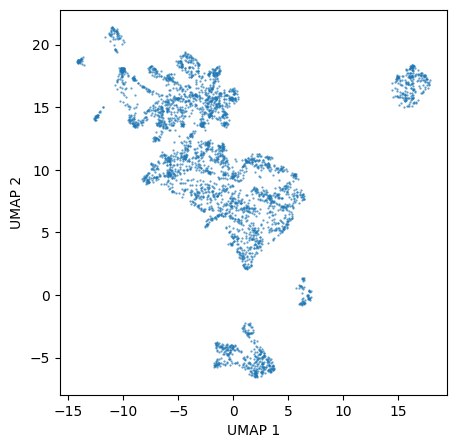

In [103]:
# now try this with a umap

import umap

reducer = umap.UMAP(n_components=2, min_dist=0.5, n_neighbors=15)
embedding = reducer.fit_transform(go_feature_matrix.T)

df_umap = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_umap['feature'] = mtrx_feature_ids.numpy()

# plot the UMAP

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', s=2, alpha=0.7, ec=None)
plt.show()

In [ ]:
# do not run, too big

min_count = 5
max_count = 100

n_test_terms = len(go_counts[(go_counts['feature'] < max_count) & (go_counts['feature'] > min_count)].index)
print('Number of test terms: {}'.format(n_test_terms))

n_cols = 6
n_rows = math.ceil(n_test_terms / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

count = 0
for test_term in go_counts[(go_counts['feature'] < max_count) & (go_counts['feature'] > min_count)].index:
    #print('GO term: {}'.format(test_term))
    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df_umap.sort_values(test_term, ascending=True), 
        x='UMAP 1', y='UMAP 2', 
        hue=test_term, size=test_term, 
        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])
    ax[count//n_cols, count%n_cols].get_legend().remove()
    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()
    ax[count//n_cols, count%n_cols].set_xticks([])
    ax[count//n_cols, count%n_cols].set_yticks([])
    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.show()
    count += 1
    #break

plt.show()

In [118]:
# we could also color the features by local-global

df_umap['feature_type'] = ['local' if x in local_features else 'global' for x in df_umap['feature']]

/tmp/ipykernel_446738/3654694070.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_umap['feature_type'] = ['local' if x in local_features else 'global' for x in df_umap['feature']]


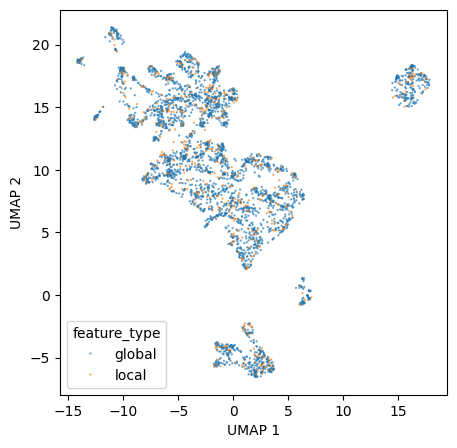

In [119]:
# plot by feature type

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='feature_type', s=2, alpha=0.7, ec=None)
plt.show()

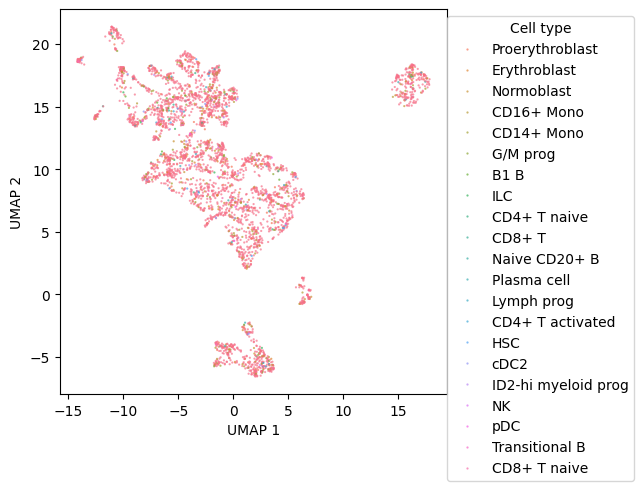

In [124]:
# now get the cell types from the local features

umap_ct = []

for feat in df_umap['feature']:
    if feat in local_features:
        for ct in cell_types:
            if feat in unique_ct_features[ct]:
                umap_ct.append(ct)
                break
    else:
        umap_ct.append('')

df_umap['celltype'] = umap_ct

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='celltype', s=2, alpha=0.7, ec=None)
plt.legend(title='Cell type', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

In [126]:
# do not run, too big

min_count = 5
max_count = 100

n_test_terms = len(go_counts[(go_counts['feature'] < max_count) & (go_counts['feature'] > min_count)].index)
print('Number of test terms: {}'.format(n_test_terms))

for test_term in go_counts[(go_counts['feature'] < max_count) & (go_counts['feature'] > min_count)].index:
    print(test_term)

"""
n_cols = 6
n_rows = math.ceil(n_test_terms / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

count = 0
for test_term in go_counts[(go_counts['feature'] < max_count) & (go_counts['feature'] > min_count)].index:
    #print('GO term: {}'.format(test_term))
    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df_umap.sort_values(test_term, ascending=True), 
        x='UMAP 1', y='UMAP 2', 
        hue=test_term, size=test_term, 
        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])
    ax[count//n_cols, count%n_cols].get_legend().remove()
    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()
    ax[count//n_cols, count%n_cols].set_xticks([])
    ax[count//n_cols, count%n_cols].set_yticks([])
    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.show()
    count += 1
    #break

plt.show()
"""

Number of test terms: 435
response to radiation
extrinsic apoptotic signaling pathway
cellular response to interleukin-7
regulation of small GTPase mediated signal transduction
protein localization to cell surface
phospholipase C-activating G protein-coupled receptor signaling pathway
negative regulation of programmed cell death
protein autoprocessing
platelet-derived growth factor receptor signaling pathway
positive regulation of gene expression
positive chemotaxis
long-chain fatty-acyl-CoA biosynthetic process
vasculogenesis
ATP biosynthetic process
negative regulation of double-strand break repair via homologous recombination
negative regulation of extrinsic apoptotic signaling pathway in absence of ligand
T cell homeostasis
negative regulation of translation
centrosome duplication
protein processing
protein transport
regulation of microtubule nucleation
transport across blood-brain barrier
mRNA processing
positive regulation of filopodium assembly
postsynapse organization
axon guid

"\nn_cols = 6\nn_rows = math.ceil(n_test_terms / n_cols)\n\nfig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))\n\ncount = 0\nfor test_term in go_counts[(go_counts['feature'] < max_count) & (go_counts['feature'] > min_count)].index:\n    #print('GO term: {}'.format(test_term))\n    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]\n    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))\n    sns.scatterplot(\n        data=df_umap.sort_values(test_term, ascending=True), \n        x='UMAP 1', y='UMAP 2', \n        hue=test_term, size=test_term, \n        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])\n    ax[count//n_cols, count%n_cols].get_legend().remove()\n    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()\n    ax[count//n_cols, count%n_cols].set_xticks([])\n    ax[count//n_cols, count%n_cols].set_yticks([])\n    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(go_feature_matrix[m

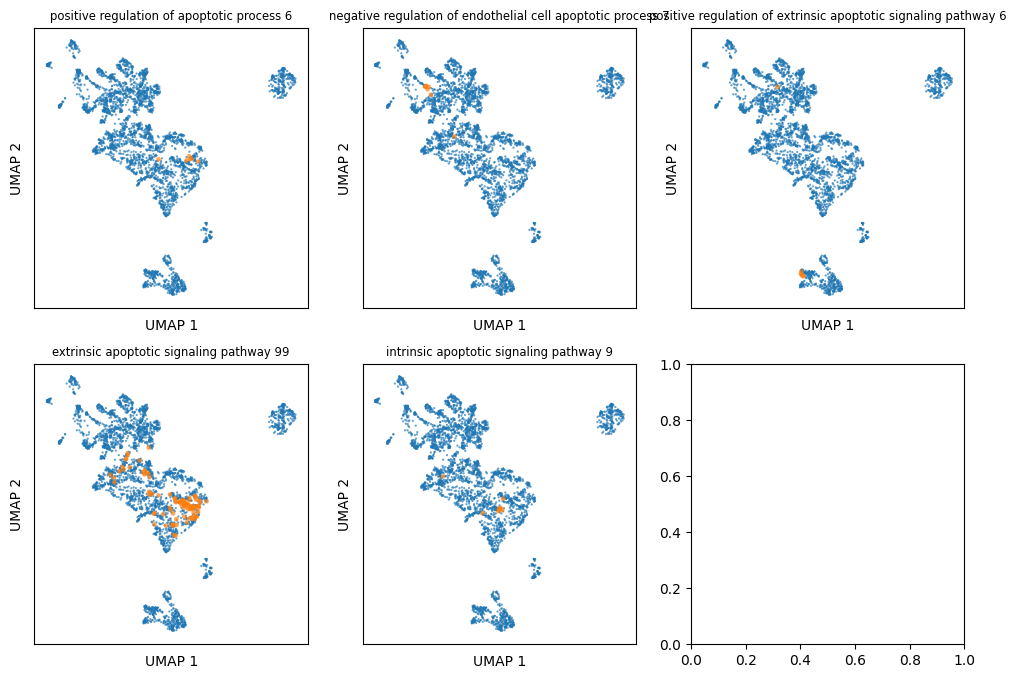

In [132]:
selected_test_terms = [
    'positive regulation of apoptotic process',
    'negative regulation of endothelial cell apoptotic process',
    'positive regulation of extrinsic apoptotic signaling pathway',
    'extrinsic apoptotic signaling pathway',
    'intrinsic apoptotic signaling pathway',
]

# make the title font size smaller
plt.rcParams.update({'axes.titlesize': 'small'})

n_cols = 3
n_rows = math.ceil(len(selected_test_terms) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

count = 0
for test_term in selected_test_terms:
    #print('GO term: {}'.format(test_term))
    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df_umap.sort_values(test_term, ascending=True), 
        x='UMAP 1', y='UMAP 2', 
        hue=test_term, size=test_term, 
        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])
    ax[count//n_cols, count%n_cols].get_legend().remove()
    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()
    ax[count//n_cols, count%n_cols].set_xticks([])
    ax[count//n_cols, count%n_cols].set_yticks([])
    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(int(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item())))
    #plt.title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.show()
    count += 1
    #break

plt.show()

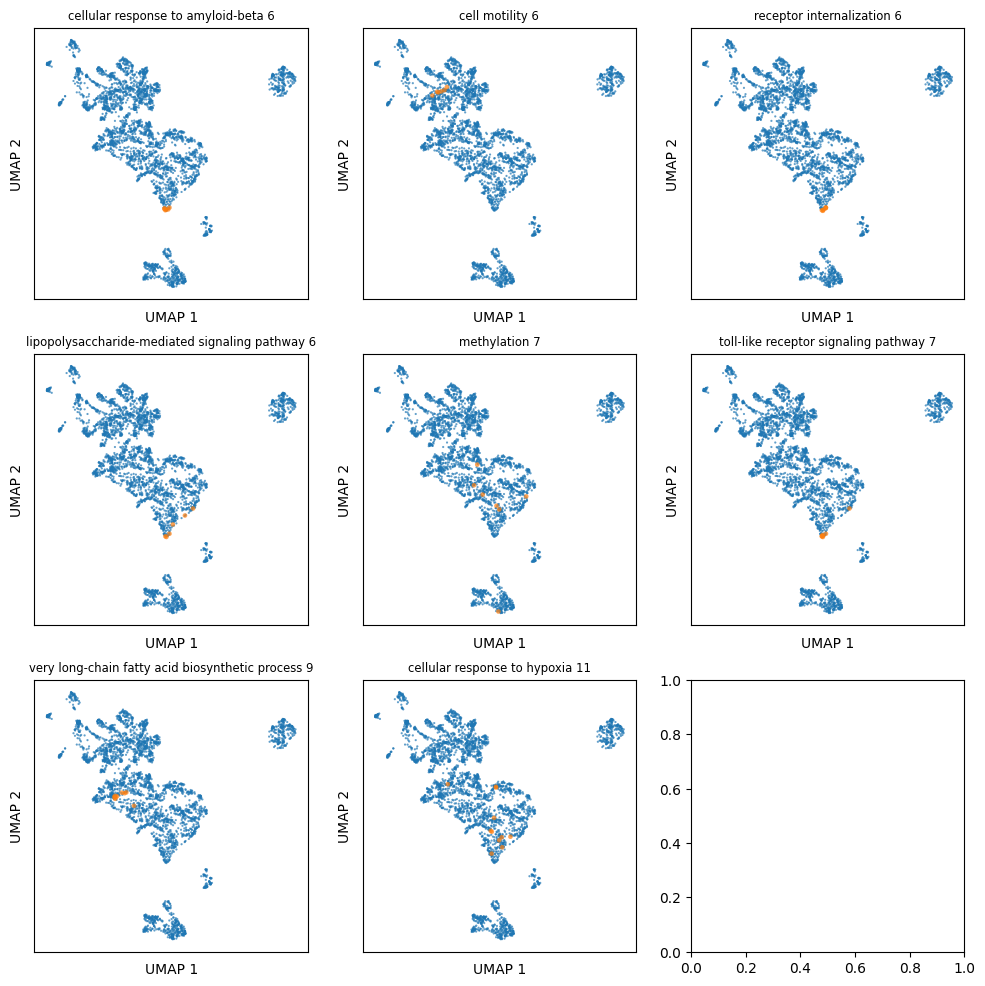

In [133]:
selected_test_terms = [
    'cellular response to amyloid-beta',
    'cell motility',
    'receptor internalization',
    'lipopolysaccharide-mediated signaling pathway',
    'methylation',
    'toll-like receptor signaling pathway',
    'very long-chain fatty acid biosynthetic process',
    'cellular response to hypoxia',
]

# make the title font size smaller
plt.rcParams.update({'axes.titlesize': 'small'})

n_cols = 3
n_rows = math.ceil(len(selected_test_terms) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

count = 0
for test_term in selected_test_terms:
    #print('GO term: {}'.format(test_term))
    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df_umap.sort_values(test_term, ascending=True), 
        x='UMAP 1', y='UMAP 2', 
        hue=test_term, size=test_term, 
        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])
    ax[count//n_cols, count%n_cols].get_legend().remove()
    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()
    ax[count//n_cols, count%n_cols].set_xticks([])
    ax[count//n_cols, count%n_cols].set_yticks([])
    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(int(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item())))
    #plt.title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.show()
    count += 1
    #break

plt.show()

/tmp/ipykernel_446738/2358788262.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
/tmp/ipykernel_446738/2358788262.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
/tmp/ipykernel_446738/2358788262.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

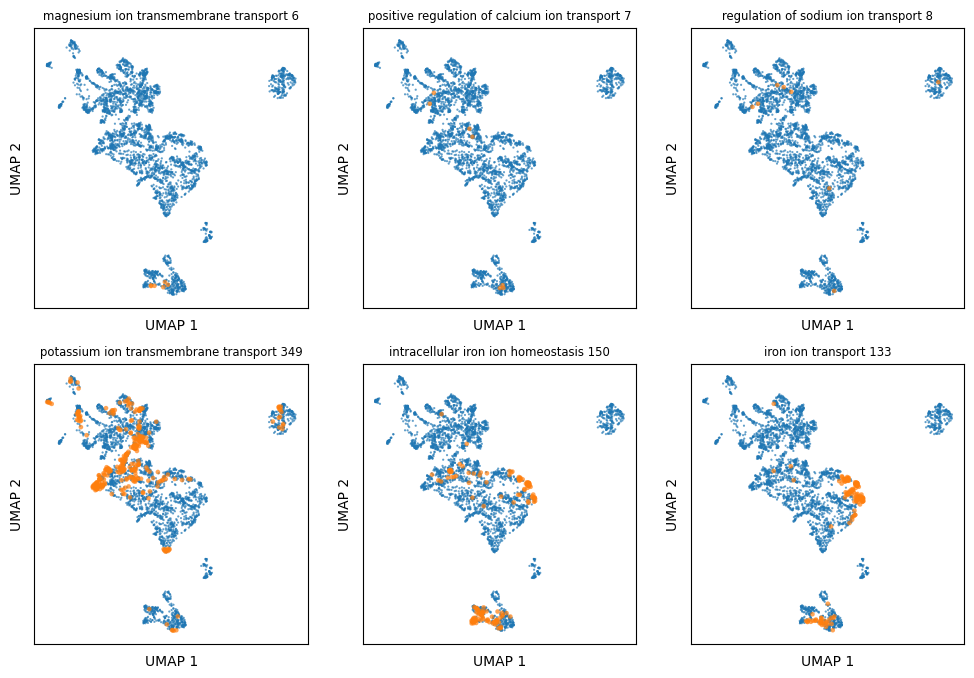

In [141]:
selected_test_terms = [
    'magnesium ion transmembrane transport',
    'positive regulation of calcium ion transport',
    'regulation of sodium ion transport',
    'potassium ion transmembrane transport',
    'intracellular iron ion homeostasis',
    'iron ion transport'
]

# make the title font size smaller
plt.rcParams.update({'axes.titlesize': 'small'})

n_cols = 3
n_rows = math.ceil(len(selected_test_terms) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

count = 0
for test_term in selected_test_terms:
    #print('GO term: {}'.format(test_term))
    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df_umap.sort_values(test_term, ascending=True), 
        x='UMAP 1', y='UMAP 2', 
        hue=test_term, size=test_term, 
        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])
    ax[count//n_cols, count%n_cols].get_legend().remove()
    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()
    ax[count//n_cols, count%n_cols].set_xticks([])
    ax[count//n_cols, count%n_cols].set_yticks([])
    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(int(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item())))
    #plt.title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.show()
    count += 1
    #break

plt.show()

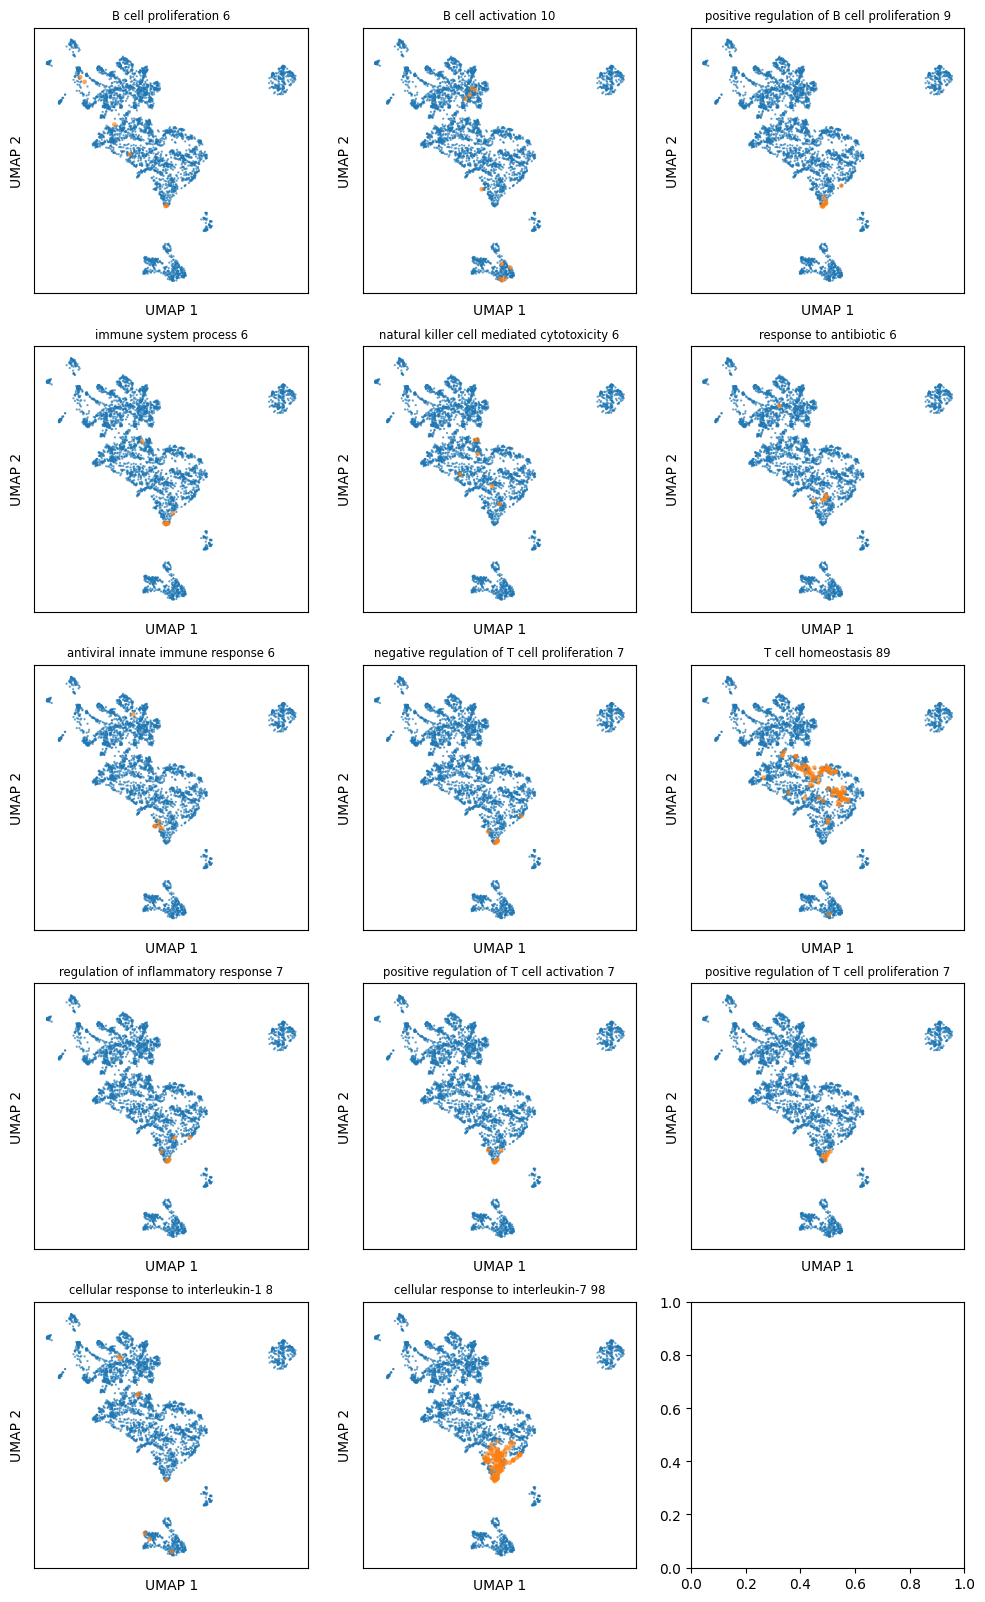

In [142]:
selected_test_terms = [
    'B cell proliferation',
    'B cell activation',
    'positive regulation of B cell proliferation',
    'immune system process',
    'natural killer cell mediated cytotoxicity',
    'response to antibiotic',
    'antiviral innate immune response',
    'negative regulation of T cell proliferation',
    'T cell homeostasis',
    'regulation of inflammatory response',
    'positive regulation of T cell activation',
    'positive regulation of T cell proliferation',
    'cellular response to interleukin-1',
    'cellular response to interleukin-7',
]

# make the title font size smaller
plt.rcParams.update({'axes.titlesize': 'small'})

n_cols = 3
n_rows = math.ceil(len(selected_test_terms) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

count = 0
for test_term in selected_test_terms:
    #print('GO term: {}'.format(test_term))
    df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(
        data=df_umap.sort_values(test_term, ascending=True), 
        x='UMAP 1', y='UMAP 2', 
        hue=test_term, size=test_term, 
        sizes=(10,2), alpha=0.7, ec=None, ax=ax[count//n_cols, count%n_cols])
    ax[count//n_cols, count%n_cols].get_legend().remove()
    #plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1)).remove()
    ax[count//n_cols, count%n_cols].set_xticks([])
    ax[count//n_cols, count%n_cols].set_yticks([])
    ax[count//n_cols, count%n_cols].set_title(test_term + ' ' + str(int(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item())))
    #plt.title(test_term + ' ' + str(go_feature_matrix[mtrx_go_names.index(test_term),:].sum().item()))
    #plt.show()
    count += 1
    #break

plt.show()

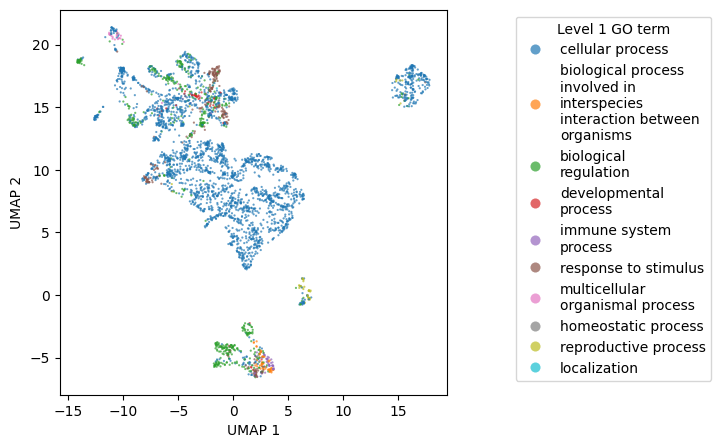

In [186]:
# color each feature by its most prevalent level 1 go term
level_1_mtrx_terms = []

for feat in mtrx_feature_ids:
    feat = feat.item()
    temp_go_term = go_df[go_df['feature'] == feat]['parent_go_name_level1'].value_counts().index[0]
    level_1_mtrx_terms.append(temp_go_term)

df_umap['level_1_go_term'] = level_1_mtrx_terms

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=2, alpha=0.7, ec=None)
# if a legend handle is longer than 20 characters, break it up
handles, labels = ax.get_legend_handles_labels()
import textwrap
new_labels = [textwrap.fill(label, 20) for label in labels]
# also make the legend markers larger by scaling
ax.legend(handles, new_labels, title='Level 1 GO term', loc='upper right', bbox_to_anchor=(1.7, 1), markerscale=5)
plt.show()

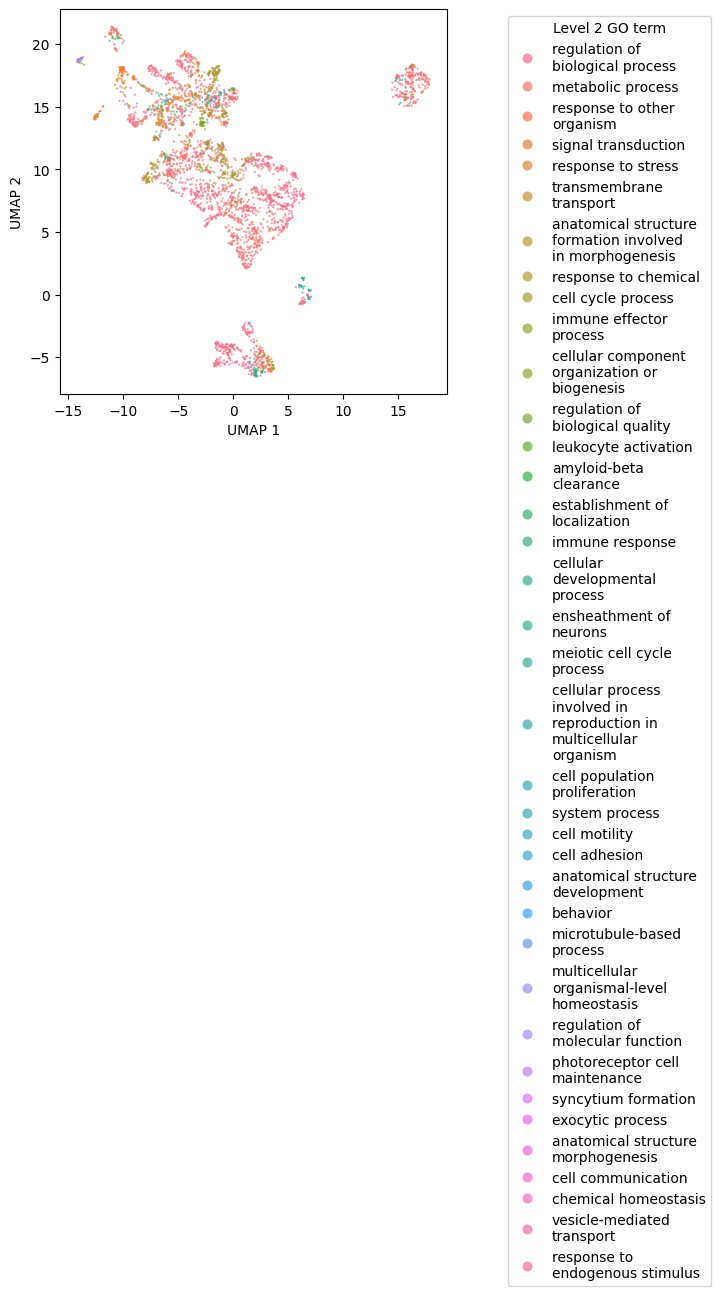

In [189]:
# color each feature by its most prevalent level 1 go term
level_2_mtrx_terms = []

for feat in mtrx_feature_ids:
    feat = feat.item()
    temp_go_term = go_df[go_df['feature'] == feat]['parent_go_name_level2'].value_counts().index[0]
    level_2_mtrx_terms.append(temp_go_term)

df_umap['level_2_go_term'] = level_2_mtrx_terms

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='level_2_go_term', s=2, alpha=0.7, ec=None)
# if a legend handle is longer than 20 characters, break it up
handles, labels = ax.get_legend_handles_labels()
import textwrap
new_labels = [textwrap.fill(label, 20) for label in labels]
# also make the legend markers larger by scaling
ax.legend(handles, new_labels, title='Level 2 GO term', loc='upper right', bbox_to_anchor=(1.7, 1), markerscale=5)
plt.show()

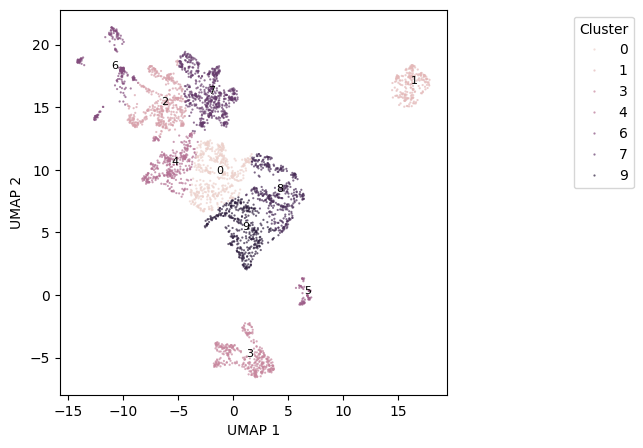

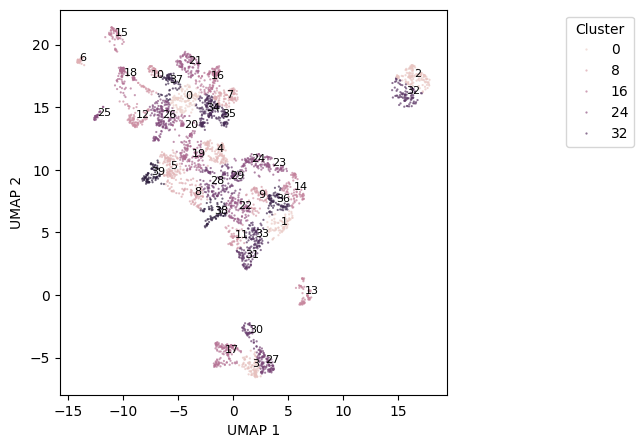

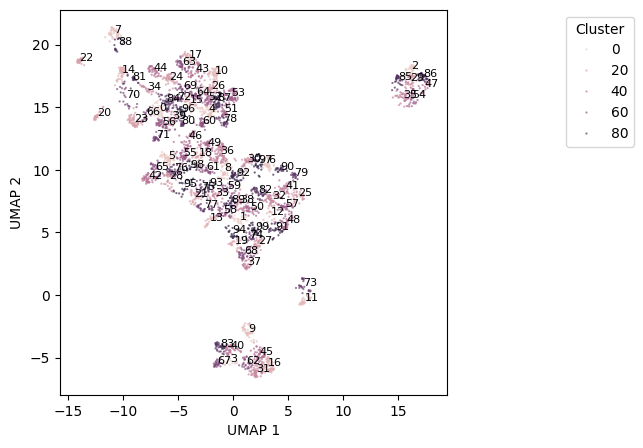

In [172]:
# perform clustering on the umap

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(embedding)
df_umap['high_level_cluster'] = kmeans.labels_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='high_level_cluster', s=2, alpha=0.7, ec=None)
for i in range(10):
    cluster_center = kmeans.cluster_centers_[i]
    ax.text(cluster_center[0], cluster_center[1], str(i), fontsize=8, color='black')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

kmeans = KMeans(n_clusters=40, random_state=0).fit(embedding)
df_umap['mid_level_cluster'] = kmeans.labels_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='mid_level_cluster', s=2, alpha=0.7, ec=None)
# add the number of the cluster over the mean
for i in range(40):
    cluster_center = kmeans.cluster_centers_[i]
    ax.text(cluster_center[0], cluster_center[1], str(i), fontsize=8, color='black')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()


kmeans = KMeans(n_clusters=100, random_state=0).fit(embedding)
df_umap['low_level_cluster'] = kmeans.labels_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='low_level_cluster', s=2, alpha=0.7, ec=None)
# add the number of the cluster over the mean
for i in range(100):
    cluster_center = kmeans.cluster_centers_[i]
    ax.text(cluster_center[0], cluster_center[1], str(i), fontsize=8, color='black')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

In [155]:
# for each cluster, get all the features and associated go terms (with counts)

umap_cluster_high = {}
for cluster in df_umap['high_level_cluster'].unique():
    temp_feats = df_umap[df_umap['high_level_cluster'] == cluster]['feature'].values
    mtrx_positions = [np.where(mtrx_feature_ids.numpy() == x)[0][0] for x in temp_feats]
    go_term_temp_counts = go_feature_matrix[:,mtrx_positions].sum(dim=1).numpy()
    temp_go_names = [mtrx_go_names[x] for x in np.where(go_term_temp_counts > 1)[0]]
    umap_cluster_high[str(cluster)] = {'features': temp_feats, 'go_names': temp_go_names}

# for each cluster, get all the features and associated go terms (with counts)

umap_cluster_low = {}
for cluster in df_umap['low_level_cluster'].unique():
    temp_feats = df_umap[df_umap['low_level_cluster'] == cluster]['feature'].values
    mtrx_positions = [np.where(mtrx_feature_ids.numpy() == x)[0][0] for x in temp_feats]
    go_term_temp_counts = go_feature_matrix[:,mtrx_positions].sum(dim=1).numpy()
    temp_go_names = [mtrx_go_names[x] for x in np.where(go_term_temp_counts > 1)[0]]
    umap_cluster_low[str(cluster)] = {'features': temp_feats, 'go_names': temp_go_names}

In [158]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.6 MB/s eta 0:00:00


In [162]:
# for each cluster, give the go names to a language model and get a one sentence summary of the function\

from transformers import pipeline

# load the model
summarizer = pipeline("summarization")

# summarize the go terms
general_message = 'This cluster shows enriched GO terms: '
end_message = 'Please provide a one-sentence summary of the function of this cluster.'

for cluster in umap_cluster_high.keys():
    temp_go_terms = list(set(umap_cluster_high[cluster]['go_names']))
    message = general_message + ' '.join(temp_go_terms) + '. ' + end_message
    print(message)
    summary = summarizer(message, max_length=50, min_length=10, do_sample=False)
    print('Cluster {}: {}'.format(cluster, summary[0]['summary_text']))
    break

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


This cluster shows enriched GO terms: embryonic cranial skeleton morphogenesis dendrite morphogenesis neuron apoptotic process chemical synaptic transmission regulation of protein phosphorylation cytoskeleton organization positive regulation of receptor internalization regulation of heart rate by cardiac conduction Notch signaling pathway regulation of autophagy erythrocyte differentiation negative regulation of DNA binding cell population proliferation neuron migration positive regulation of protein phosphorylation forebrain development sprouting angiogenesis positive regulation of cytosolic calcium ion concentration placenta development regulation of GTPase activity negative regulation of neuron apoptotic process positive regulation of interleukin-6 production cellular response to epinephrine stimulus G protein-coupled receptor signaling pathway, coupled to cyclic nucleotide second messenger regulation of canonical NF-kappaB signal transduction positive regulation of ERK1 and ERK2 ca

In [164]:
general_message = ' shows enriched GO terms: '
end_message = 'Please provide a one-sentence summary of the function of this cluster.'

for cluster in umap_cluster_high.keys():
    temp_go_terms = list(set(umap_cluster_high[cluster]['go_names']))
    message = f'Cluster {cluster}' + general_message + ' '.join(temp_go_terms) + '. ' + end_message
    print(message)
    break

Cluster 6 shows enriched GO terms: embryonic cranial skeleton morphogenesis dendrite morphogenesis neuron apoptotic process chemical synaptic transmission regulation of protein phosphorylation cytoskeleton organization positive regulation of receptor internalization regulation of heart rate by cardiac conduction Notch signaling pathway regulation of autophagy erythrocyte differentiation negative regulation of DNA binding cell population proliferation neuron migration positive regulation of protein phosphorylation forebrain development sprouting angiogenesis positive regulation of cytosolic calcium ion concentration placenta development regulation of GTPase activity negative regulation of neuron apoptotic process positive regulation of interleukin-6 production cellular response to epinephrine stimulus G protein-coupled receptor signaling pathway, coupled to cyclic nucleotide second messenger regulation of canonical NF-kappaB signal transduction positive regulation of ERK1 and ERK2 casca

In [ ]:
# chatGPT answer for first cluster:
"""Cluster 6 is primarily involved in various processes related to cell signaling, morphogenesis, neuronal function, immune response, and cellular regulation, with a particular emphasis on growth, differentiation, apoptosis, and communication pathways such as NF-kappaB, Notch, and G protein-coupled receptors."""

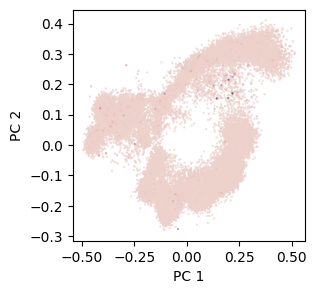

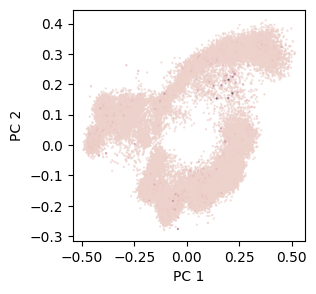

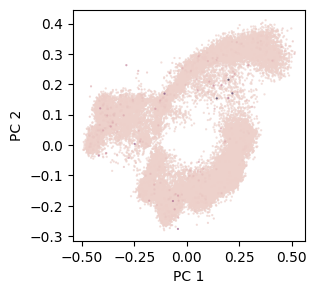

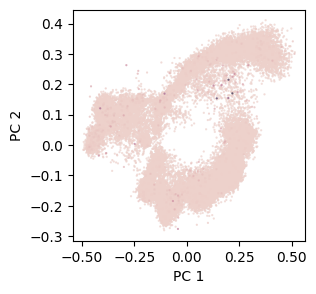

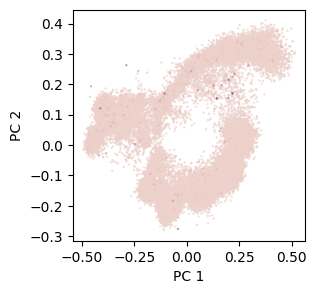

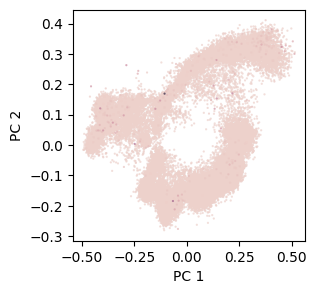

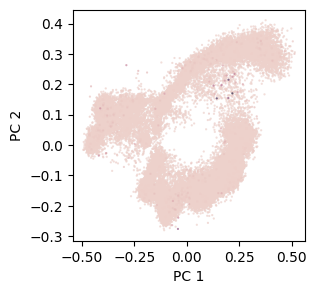

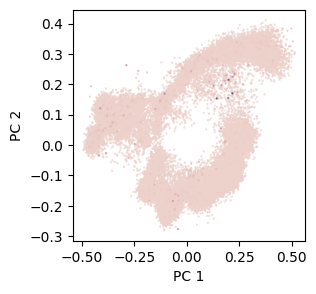

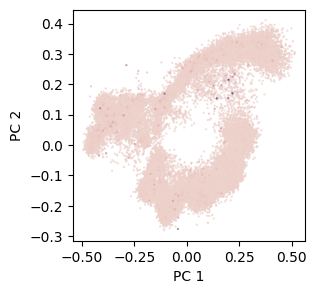

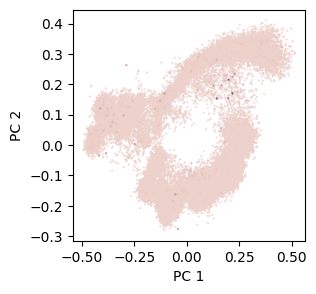

In [170]:
# plot the sum of activations for all features in cluster 70

for i in range(10):
    feats_cluster = df_umap[df_umap['high_level_cluster'] == i]['feature'].values

    df_pca['cluster'] = np.log1p(torch.sum(activations[:,feats_cluster], dim=1).numpy())

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.scatterplot(data=df_pca.sort_values('cluster', ascending=True), x='PC 1', y='PC 2', hue='cluster', s=2, alpha=0.7, ec=None)
    plt.legend(title=f'Cluster {i}', loc='upper right', bbox_to_anchor=(1.5, 1)).remove()
    plt.show()

In [165]:
general_message = ' shows enriched GO terms: '
end_message = 'Please provide a one-sentence summary of the function of this cluster.'

for cluster in umap_cluster_low.keys():
    temp_go_terms = list(set(umap_cluster_low[cluster]['go_names']))
    message = f'Cluster {cluster}' + general_message + ' '.join(temp_go_terms) + '. ' + end_message
    print(message)
    break

Cluster 70 shows enriched GO terms: positive regulation of angiogenesis cellular response to epinephrine stimulus G protein-coupled receptor signaling pathway, coupled to cyclic nucleotide second messenger regulation of canonical NF-kappaB signal transduction heme biosynthetic process positive regulation of ERK1 and ERK2 cascade dendrite morphogenesis neuron apoptotic process chemical synaptic transmission regulation of GTPase activity cellular response to cAMP cell morphogenesis blood coagulation spermatid development hematopoietic stem cell proliferation cellular response to insulin stimulus potassium ion transmembrane transport negative regulation of programmed cell death positive regulation of receptor internalization positive regulation of gene expression regulation of small GTPase mediated signal transduction protein localization to cell surface cellular response to calcium ion regulation of heart rate by cardiac conduction definitive hemopoiesis positive regulation of peptidyl-t

In [ ]:
# chatGPT answer for first cluster:
"""Cluster 70 is primarily involved in processes related to angiogenesis, neuronal function, hematopoiesis, cell signaling, and regulation of cell survival, with a focus on pathways such as NF-kappaB, G protein-coupled receptors, ERK, and PI3K/AKT, impacting cellular responses to stimuli like epinephrine, estradiol, and insulin."""

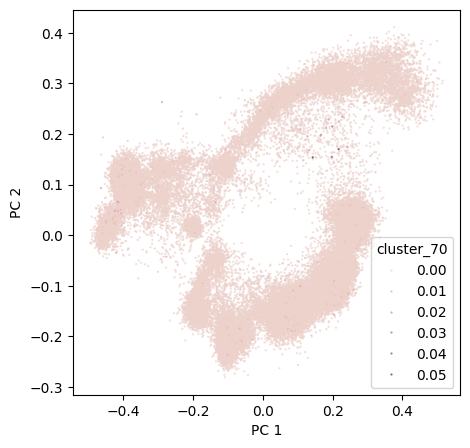

In [168]:
# plot the sum of activations for all features in cluster 70

feats_cluster_70 = df_umap[df_umap['low_level_cluster'] == 70]['feature'].values

df_pca['cluster_70'] = torch.sum(activations[:,feats_cluster_70], dim=1).numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_pca.sort_values('cluster_70'), x='PC 1', y='PC 2', hue='cluster_70', s=2, alpha=0.7, ec=None)
plt.show()


[ 313  427  521  622  745  853 1059 1088 1219 1377 1398 1431 1460 1775
 1807 1965 2078 2184 2215 2355 2414 2463 2533 2717 2767 3063 3094 3400
 3411 3474 3488 3497 3616 3735 3970 4026 4153 4488 4527 4689 4736 4747
 4752 4994 5589 5747 6049 6315 6601 6802 7123 7142 7205 7301 7993 8551
 8689 8710 8735 8775 8882 9038 9207 9235 9299 9477 9671 9764 9784 9847
 9958]


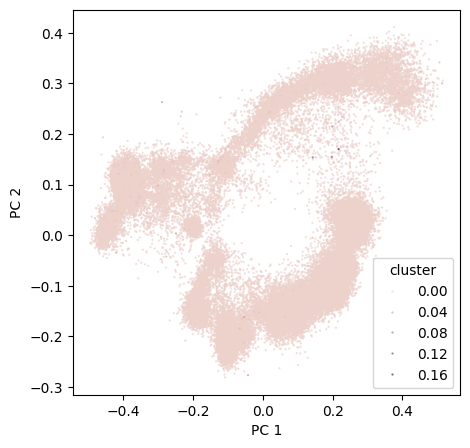

In [176]:
# plot the sum of activations for all features in cluster 70

feats_cluster = df_umap[df_umap['mid_level_cluster'] == 31]['feature'].values
print(feats_cluster)

df_pca['cluster'] = np.log1p(torch.sum(activations[:,feats_cluster], dim=1).numpy())

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_pca.sort_values('cluster', ascending=True), x='PC 1', y='PC 2', hue='cluster', s=2, alpha=0.7, ec=None)
plt.show()


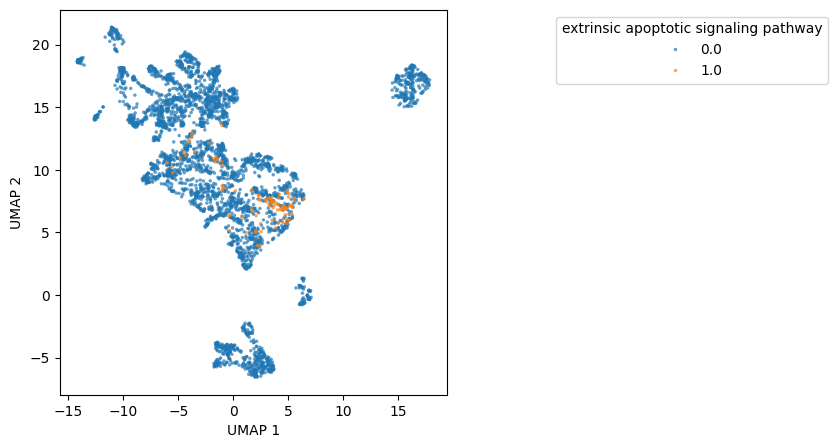

In [ ]:
# highlight a specific go term that is interesting and appears in many features

test_term = 'extrinsic apoptotic signaling pathway'

df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]

# plot the UMAP

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap.sort_values(test_term), x='UMAP 1', y='UMAP 2', hue=test_term, s=5, alpha=0.7, ec=None)
plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1))
plt.show()

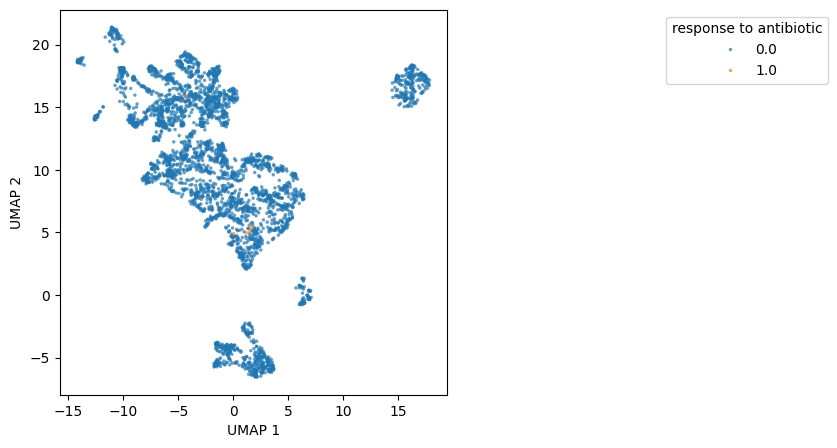

In [107]:
# highlight a specific go term that is interesting and appears in many features

test_term = 'response to antibiotic'

df_umap[test_term] = go_feature_matrix[mtrx_go_names.index(test_term),:]

# plot the UMAP

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap.sort_values(test_term), x='UMAP 1', y='UMAP 2', hue=test_term, s=5, alpha=0.7, ec=None)
plt.legend(title=test_term, loc='upper right', bbox_to_anchor=(2., 1))
plt.show()

In [36]:
# sort all go_df go ids top-down by level hierarchy

go_ids_sorted = []

level_1_unique = go_df['parent_go_id_level1'].unique()
for l1_term in level_1_unique:
    go_ids_sorted_temp = []
    go_ids_sorted_temp.append(l1_term)
    level_2_unique = go_df[go_df['parent_go_id_level1'] == l1_term]['parent_go_id_level2'].unique()
    for l2_term in level_2_unique:
        go_ids_sorted_temp.append(l2_term)
        level_3_unique = go_df[go_df['parent_go_id_level2'] == l2_term]['parent_go_id_level3'].unique()
        for l3_term in level_3_unique:
            go_ids_sorted_temp.append(l3_term)
            level_4_unique = go_df[go_df['parent_go_id_level3'] == l3_term]['parent_go_id_level4'].unique()
            for l4_term in level_4_unique:
                go_ids_sorted_temp.append(l4_term)
            # now append all go_ids that appear with this l4_term
            go_df_temp = go_df[go_df['parent_go_id_level4'] == l4_term]
            for go_id in go_df_temp['go_id'].unique():
                go_ids_sorted_temp.append(go_id)
    go_ids_sorted.append(go_ids_sorted_temp)

print(len(go_ids_sorted))

14


In [37]:
# check the overlaps between all first level go terms
for i in range(len(go_ids_sorted)):
    for j in range(i+1, len(go_ids_sorted)):
        print('Level 1 terms {} and {} with {} and {} terms'.format(i, j, len(go_ids_sorted[i]), len(go_ids_sorted[j])))
        overlapping = set(go_ids_sorted[i]).intersection(set(go_ids_sorted[j]))
        print('Number of overlapping go terms: {}'.format(len(overlapping)))

Level 1 terms 0 and 1 with 6559 and 1041 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 2 with 6559 and 2891 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 3 with 6559 and 1843 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 4 with 6559 and 2211 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 5 with 6559 and 470 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 6 with 6559 and 1507 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 7 with 6559 and 313 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 8 with 6559 and 647 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 9 with 6559 and 357 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 10 with 6559 and 153 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 11 with 6559 and 301 terms
Number of overlapping go terms: 148
Level 1 terms 0 and 12 with 6559 and 151 terms
Number of overlapping go terms: 148
Level 1 

In [38]:
overlapping

{'',
 'GO:0000226',
 'GO:0000278',
 'GO:0000902',
 'GO:0001503',
 'GO:0001525',
 'GO:0001541',
 'GO:0001556',
 'GO:0001568',
 'GO:0001666',
 'GO:0001675',
 'GO:0001824',
 'GO:0001833',
 'GO:0002250',
 'GO:0002376',
 'GO:0002437',
 'GO:0002764',
 'GO:0002931',
 'GO:0003333',
 'GO:0006091',
 'GO:0006413',
 'GO:0006457',
 'GO:0006884',
 'GO:0006887',
 'GO:0006897',
 'GO:0006914',
 'GO:0006935',
 'GO:0006952',
 'GO:0006955',
 'GO:0006959',
 'GO:0006979',
 'GO:0007017',
 'GO:0007018',
 'GO:0007051',
 'GO:0007059',
 'GO:0007062',
 'GO:0007098',
 'GO:0007099',
 'GO:0007131',
 'GO:0007155',
 'GO:0007166',
 'GO:0007186',
 'GO:0007204',
 'GO:0007267',
 'GO:0007275',
 'GO:0007281',
 'GO:0007283',
 'GO:0007288',
 'GO:0007338',
 'GO:0007565',
 'GO:0007566',
 'GO:0007584',
 'GO:0007585',
 'GO:0007596',
 'GO:0007611',
 'GO:0007623',
 'GO:0007626',
 'GO:0008217',
 'GO:0008283',
 'GO:0008333',
 'GO:0008360',
 'GO:0008608',
 'GO:0009314',
 'GO:0009408',
 'GO:0009409',
 'GO:0009410',
 'GO:0009611',
 'GO:

In [39]:
go_ids_sorted_sorted = []
for go_ids in go_ids_sorted:
    unique_set = set(go_ids).difference(overlapping)
    go_ids_sorted_sorted.extend(list(unique_set))
go_ids_sorted_sorted.extend(list(overlapping))

In [43]:
len(go_ids_sorted_sorted)

850

In [45]:
activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

/tmp/ipykernel_446738/615365454.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_ac

In [46]:
# create a matrix of all go terms and features

go_feature_matrix = torch.zeros((len(go_ids_sorted_sorted), activations.shape[1]))

for i, go_id in enumerate(go_ids_sorted_sorted):
    go_df_temp = go_df[go_df['go_id'] == go_id]
    for feat in go_df_temp['feature']:
        go_feature_matrix[i, feat] = 1

# remove all columns with zero sum (unused features)
go_feature_matrix = go_feature_matrix[:,torch.where(go_feature_matrix.sum(dim=0) > 0)[0]]

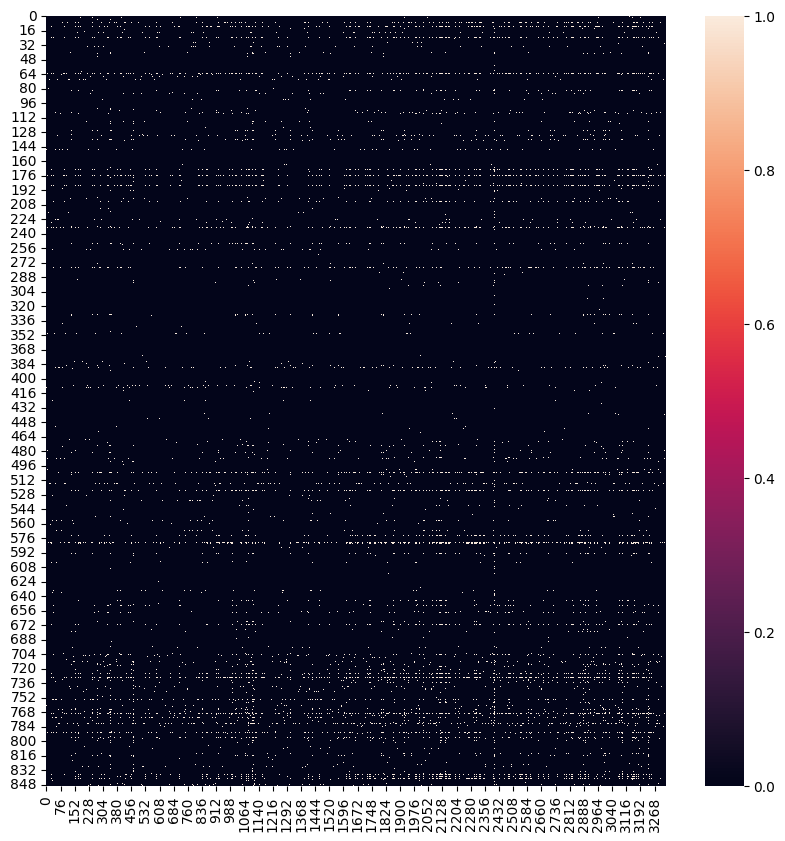

In [47]:
# plot a heatmap of the go_feature_matrix

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(go_feature_matrix, ax=ax)
plt.show()

## ATAC